# DDRA Joaquin

## General Idea
The idea is to start with a very simple model with basic Booking attributes. This should serve as a first understanding of what can bring value in the data-driven risk assessment of new dash protected bookings.

## Initial setup
This first section just ensures that the connection to DWH works correctly.

In [63]:
# This script connects to a Data Warehouse (DWH) using PostgreSQL. 
# This should be common for all Notebooks, but you might need to adjust the path to the `dwh_utils` module.

import sys
import os
sys.path.append(os.path.abspath("../../utils"))  # Adjust path if needed

from dwh_utils import read_credentials, create_postgres_engine, query_to_dataframe, test_connection

# --- Connect to DWH ---
creds = read_credentials()
dwh_pg_engine = create_postgres_engine(creds)

# --- Test Query ---
test_connection()

🔌 Testing connection using credentials at: /home/joaquin/.superhog-dwh/credentials.yml
✅ Connection successful.


## Data Extraction
In this section we extract the data for our first attempt on Basic Booking Attributes modelling.

This SQL query retrieves a clean and relevant subset of booking data for our model. It includes:
- A **unique booking ID**
- Key **numeric features** such as number of services, time between booking creation and check-in, and number of nights
- Several **categorical (boolean) features** related to service usage
- A **target variable** (`has_resolution_incident`) indicating whether a resolution incident occurred

Filters applied being:
1. Bookings from **"New Dash" users** with a valid deal ID
2. Only **protected bookings**, i.e., those with Protection or Deposit Management services
3. Bookings flagged for **risk categorisation** (excluding incomplete/rejected ones)
4. Bookings that are **already completed**

The result is converted into a pandas DataFrame for further processing and modeling.


In [64]:
# Initialise all imports needed for the Notebook
from sklearn.model_selection import (
    train_test_split, 
    GridSearchCV
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectKBest, f_classif
import pandas as pd
import numpy as np
from datetime import date
from sklearn.metrics import (
    roc_auc_score, 
    average_precision_score,
    classification_report,
    roc_curve, 
    auc,
    precision_recall_curve,
    precision_score,
    recall_score,
    fbeta_score,
    confusion_matrix
)
import matplotlib.pyplot as plt
import shap
import math

In [65]:
# Query to extract data
data_extraction_query = """
with
    int_core__verification_requests as (
        select *
        from intermediate.int_core__verification_requests
        where created_date_utc >= '2024-10-21'
    ),
    int_core__bookings as (
        select *
        from intermediate.int_core__bookings
        where created_date_utc >= '2024-10-21'
    ),
    stg_core__verification as (
        select *
        from staging.stg_core__verification
        where created_date_utc >= '2024-10-21'
    ),
    int_core__guest_journey_payments as (
        select *
        from intermediate.int_core__guest_journey_payments
        where payment_due_date_utc >= '2024-10-21'
    ),
    filtered_bookings as (
        select *
        from intermediate.int_booking_summary
        where
            is_user_in_new_dash = true
            and is_missing_id_deal = false
            and (
                has_protection_service_business_type
                or has_deposit_management_service_business_type
            )
            and is_booking_flagged_as_risk is not null
            and is_booking_past_completion_date = true
            and booking_created_date_utc < '2025-06-25'
    ),
    previous_booking_counts as (
        select
            id_booking,
            id_accommodation,
            id_user_guest,
            booking_check_in_date_utc,
            booking_check_out_date_utc,
            count(*) over (
                partition by id_accommodation
                order by booking_check_in_date_utc
                rows between unbounded preceding and 1 preceding
            ) as previous_bookings_in_listing_count,
            count(*) over (
                partition by id_user_guest
                order by booking_check_in_date_utc
                rows between unbounded preceding and 1 preceding
            ) as previous_guest_bookings_count
        from filtered_bookings
    ),
    listing_info as (
        select
            id_accommodation,
            address_line_1 as listing_address,
            town as listing_town,
            country_name as listing_country,
            postcode as listing_postcode,
            number_of_bedrooms,
            number_of_bathrooms,
            friendly_name as listing_description,
            id_user_host
        from intermediate.int_core__accommodation
    ),
    host_info as (
        select
            scu.id_user as id_user_host,
            icuh.account_type,
            icuh.active_pms_list,
            scc.country_name,
            scu.billing_town,
            scu.billing_postcode,
            scu.id_billing_country,
            extract(year from age(current_date, scu.date_of_birth)) as host_age,
            extract(
                month from age(current_date, scu.joined_date_utc)
            ) as host_months_with_truvi
        from staging.stg_core__user scu
        left join
            staging.stg_core__country scc on scu.id_billing_country = scc.id_country
        left join
            intermediate.int_core__user_host icuh on icuh.id_user_host = scu.id_user
    ),
    guest_info as (
        select
            scu.id_user as id_user_guest,
            scc.country_name,
            scu.billing_town,
            scu.billing_postcode,
            scu.id_billing_country,
            extract(year from age(current_date, scu.date_of_birth)) as guest_age,
            scu.email,
            scu.phone_number
        from staging.stg_core__user scu
        left join
            staging.stg_core__country scc on scu.id_billing_country = scc.id_country
    ),
    host_listing_counts as (
        select id_user_host, count(*) as number_of_listings_of_host
        from intermediate.int_core__accommodation
        where is_active = true
        group by id_user_host
    ),
    listing_incident_counts as (
        select
            i.created_date_utc::date as date_day,
            i.id_accommodation,
            count(*) over (
                partition by i.id_accommodation
                order by i.created_date_utc::date
                rows between unbounded preceding and current row
            ) as number_of_previous_incidents_in_listing,
            count(i.calculated_payout_amount_in_txn_currency) over (
                partition by i.id_accommodation
                order by i.created_date_utc::date
                rows between unbounded preceding and current row
            ) as number_of_previous_payouts_in_listing
        from intermediate.int_resolutions__incidents i
        where
            i.id_accommodation is not null
            and i.created_date_utc::date between '2024-10-21' and current_date
        order by i.id_accommodation, date_day
    ),
    guest_incident_counts as (
        select
            i.created_date_utc::date as date_day,
            i.id_user_guest,
            count(*) over (
                partition by i.id_user_guest
                order by i.created_date_utc::date
                rows between unbounded preceding and current row
            ) as number_of_previous_incidents_of_guest
        from intermediate.int_resolutions__incidents i
        where
            i.id_user_guest is not null
            and i.created_date_utc::date between '2024-10-21' and current_date
        order by i.id_user_guest, date_day
    ),
    host_incident_counts as (
        select
            i.created_date_utc::date as date_day,
            i.id_user_host,
            count(*) over (
                partition by i.id_user_host
                order by i.created_date_utc::date
                rows between unbounded preceding and current row
            ) as number_of_previous_incidents_of_host,
            count(i.calculated_payout_amount_in_txn_currency) over (
                partition by i.id_user_host
                order by i.created_date_utc::date
                rows between unbounded preceding and current row
            ) as number_of_previous_payouts_of_host
        from intermediate.int_resolutions__incidents i
        where
            i.id_user_host is not null
            and i.created_date_utc::date between '2024-10-21' and current_date
        order by i.id_user_host, date_day
    ),
    verification_requests as (
        select
            icvr.id_verification_request,
            extract(
                day
                from
                    age(
                        icvr.verification_estimated_started_date_utc,
                        icb.created_date_utc
                    )
            ) as days_to_start_verification,
            extract(
                day
                from
                    age(
                        icvr.verification_estimated_completed_date_utc,
                        icvr.verification_estimated_started_date_utc
                    )
            ) as days_to_complete_verification,
            -- CSAT Results
            gsr.experience_rating as guest_csat_score,
            gsr.guest_comments as guest_csat_comments,
            -- GUEST_PRODUCT fields
            max(
                case
                    when guest_journey_product_type = 'GUEST_PRODUCT' then product_name
                end
            ) as guest_product_name,
            max(
                case when guest_journey_product_type = 'GUEST_PRODUCT' then currency end
            ) as guest_currency,
            max(
                case
                    when guest_journey_product_type = 'GUEST_PRODUCT'
                    then total_amount_in_txn_currency
                end
            ) as guest_total_amount,
            -- VERIFICATION_PRODUCT fields
            max(
                case
                    when guest_journey_product_type = 'VERIFICATION_PRODUCT'
                    then product_name
                end
            ) as verification_product_name,
            max(
                case
                    when guest_journey_product_type = 'VERIFICATION_PRODUCT'
                    then currency
                end
            ) as verification_currency,
            max(
                case
                    when guest_journey_product_type = 'VERIFICATION_PRODUCT'
                    then total_amount_in_txn_currency
                end
            ) as verification_total_amount,
            -- Verification Results
            max(
                case when scv.verification = 'Screening' then id_verification_status end
            ) as screening_status,
            max(
                case
                    when scv.verification = 'GovernmentId' then id_verification_status
                end
            ) as government_id_status,
            max(
                case when scv.verification = 'Contract' then id_verification_status end
            ) as contract_status,
            max(
                case
                    when scv.verification = 'SelfieConfidenceScore'
                    then id_verification_status
                end
            ) as selfie_confidence_score_status,
            max(
                case
                    when scv.verification = 'PaymentValidation'
                    then id_verification_status
                end
            ) as payment_validation_status,
            max(
                case when scv.verification = 'FirstName' then id_verification_status end
            ) as first_name_status,
            max(
                case
                    when scv.verification = 'DateOfBirth' then id_verification_status
                end
            ) as date_of_birth_status,
            max(
                case when scv.verification = 'LastName' then id_verification_status end
            ) as last_name_status,
            max(
                case
                    when scv.verification = 'AutohostPartner'
                    then id_verification_status
                end
            ) as autohost_partner_status,
            max(
                case
                    when scv.verification = 'CriminalRecord' then id_verification_status
                end
            ) as criminal_record_status
        from int_core__verification_requests icvr
        left join
            int_core__bookings icb
            on icb.id_verification_request = icvr.id_verification_request
        left join
            stg_core__verification scv
            on scv.id_verification_request = icvr.id_verification_request
        left join
            int_core__guest_journey_payments gjp
            on gjp.id_verification_request = icb.id_verification_request
        left join
            intermediate.int_core__guest_satisfaction_responses gsr
            on gsr.id_verification_request = icvr.id_verification_request
            and scv.verification in (
                'Screening',
                'GovernmentId',
                'Contract',
                'SelfieConfidenceScore',
                'PaymentValidation',
                'FirstName',
                'DateOfBirth',
                'LastName',
                'AutohostPartner',
                'CriminalRecord'
            )
        group by 1, 2, 3, 4, 5
    )
select
    fb.id_booking,
    extract(day from age(fb.booking_check_in_date_utc, fb.booking_created_date_utc)) as days_from_booking_creation_to_check_in,
    extract(day from age(fb.booking_check_out_date_utc, fb.booking_check_in_date_utc)) as number_of_nights,
    -- Host Info
    hi.billing_town as host_town,
    hi.country_name as host_country,
    hi.billing_postcode as host_postcode,
    hi.host_age,
    hi.host_months_with_truvi,
    hi.account_type as host_account_type,
    hi.active_pms_list as host_active_pms_list,
    coalesce(hlc.number_of_listings_of_host, 0) as number_of_listings_of_host,
    coalesce(
        hic.number_of_previous_incidents_of_host, 0
    ) as number_of_previous_incidents_of_host,
    coalesce(
        hic.number_of_previous_payouts_of_host, 0
    ) as number_of_previous_payouts_of_host,
    -- Guest Info
    gi.billing_town as guest_town,
    gi.country_name as guest_country,
    gi.billing_postcode as guest_postcode,
    gi.guest_age,
    coalesce(
        pbc.previous_guest_bookings_count, 0
    ) as number_of_previous_bookings_of_guest,
    coalesce(
        gic.number_of_previous_incidents_of_guest, 0
    ) as number_of_previous_incidents_of_guest,
    case
        when pbc.previous_bookings_in_listing_count > 0 then true else false
    end as has_guest_previously_booked_same_listing,
    -- Listing Info
    li.listing_address,
    li.listing_town,
    li.listing_country,
    li.listing_postcode,
    li.number_of_bedrooms as listing_number_of_bedrooms,
    li.number_of_bathrooms as listing_number_of_bathrooms,
    li.listing_description,
    coalesce(pbc.previous_bookings_in_listing_count, 0) as previous_bookings_in_listing_count,
    coalesce(lic.number_of_previous_incidents_in_listing, 0) as number_of_previous_incidents_in_listing,
    coalesce(lic.number_of_previous_payouts_in_listing, 0) as number_of_previous_payouts_in_listing,
    -- Verification Info
    case
        when fb.id_verification_request is null then 0
        else vr.days_to_start_verification
    end as days_to_start_verification,
    case 
        when vr.id_verification_request is null then 0
        else vr.days_to_complete_verification
    end as days_to_complete_verification,
    vr.screening_status,
    vr.government_id_status,
    vr.contract_status,
    vr.selfie_confidence_score_status,
    vr.payment_validation_status,
    vr.first_name_status,
    vr.date_of_birth_status,
    vr.last_name_status,
    vr.autohost_partner_status,
    vr.criminal_record_status,
    vr.guest_csat_score,
    vr.guest_csat_comments,
    -- Boolean features
    gi.email is not null as guest_has_email,
    gi.phone_number is not null as guest_has_phone_number,
    case 
        when gi.billing_town is null or li.listing_town is null then null 
        when gi.billing_town = li.listing_town 
        then true else false 
    end as is_guest_from_listing_town,
    case 
        when gi.country_name is null or li.listing_country is null then null
        when gi.country_name = li.listing_country 
        then true else false 
    end as is_guest_from_listing_country,
    case 
        when gi.billing_postcode is null or li.listing_postcode is null then null
        when gi.billing_postcode = li.listing_postcode 
        then true else false 
    end as is_guest_from_listing_postcode,
    case 
        when hi.billing_town is null or li.listing_town is null then null
        when hi.billing_town = li.listing_town 
        then true else false 
    end as is_host_from_listing_town,
    case 
        when hi.country_name is null or li.listing_country is null then null
        when hi.country_name = li.listing_country 
        then true else false 
    end as is_host_from_listing_country,
    case 
        when hi.billing_postcode is null or li.listing_postcode is null then null
        when hi.billing_postcode = li.listing_postcode 
        then true else false 
    end as is_host_from_listing_postcode,
    case
        when vr.days_to_complete_verification is null then false
        else true
    end as has_completed_verification,
    -- Numeric features
    fb.number_of_applied_services,
    fb.number_of_applied_upgraded_services,
    fb.number_of_applied_billable_services,
    fb.booking_check_in_date_utc
    - fb.booking_created_date_utc as booking_days_to_check_in,
    fb.booking_number_of_nights,
    -- Categorical features
    fb.has_verification_request,
    fb.has_billable_services,
    fb.has_upgraded_screening_service_business_type,
    fb.has_deposit_management_service_business_type,
    fb.has_protection_service_business_type,
    -- Target
    fb.has_resolution_incident
from filtered_bookings fb
left join previous_booking_counts pbc on fb.id_booking = pbc.id_booking
left join listing_info li on li.id_accommodation = fb.id_accommodation
left join host_info hi on hi.id_user_host = fb.id_user_host
left join guest_info gi on gi.id_user_guest = fb.id_user_guest
left join host_listing_counts hlc on li.id_user_host = hlc.id_user_host
left join
    lateral(
        select *
        from listing_incident_counts lic
        where
            lic.id_accommodation = fb.id_accommodation
            and lic.date_day <= fb.booking_check_in_date_utc
        order by lic.date_day desc
        limit 1
    ) lic
    on true
left join
    lateral(
        select *
        from guest_incident_counts gic
        where
            gic.id_user_guest = fb.id_user_guest
            and gic.date_day <= fb.booking_check_in_date_utc
        order by gic.date_day desc
        limit 1
    ) gic
    on true
left join
    lateral(
        select *
        from host_incident_counts hic
        where
            hic.id_user_host = fb.id_user_host
            and hic.date_day <= fb.booking_check_in_date_utc
        order by hic.date_day desc
        limit 1
    ) hic
    on true
left join
    verification_requests vr on vr.id_verification_request = fb.id_verification_request
"""

# Retrieve Data from Query
# df_extraction = query_to_dataframe(engine=dwh_pg_engine, query=data_extraction_query)
df_extraction = pd.read_csv("/home/joaquin/data-jupyter-notebooks/data_driven_risk_assessment/experiments/data.csv")
print(df_extraction.head())
print(f"Total Bookings: {len(df_extraction):,}")


   id_booking  days_from_booking_creation_to_check_in  number_of_nights  \
0      919656                                    26.0               4.0   
1      926634                                    17.0               3.0   
2      931082                                    20.0               7.0   
3      931086                                    15.0               3.0   
4      931096                                     8.0               5.0   

    host_town    host_country host_postcode  host_age  host_months_with_truvi  \
0  Madison CT   United States         06443     125.0                     8.0   
1  Madison CT   United States         06443     125.0                     8.0   
2      London  United Kingdom       N16 6DD     125.0                     8.0   
3      London  United Kingdom       N16 6DD     125.0                     8.0   
4      London  United Kingdom       N16 6DD     125.0                     8.0   

                   host_account_type host_active_pms_list  \
0

/tmp/ipykernel_51877/805553034.py:455: DtypeWarning: Columns (50) have mixed types. Specify dtype option on import or set low_memory=False.
  df_extraction = pd.read_csv("/home/joaquin/data-jupyter-notebooks/data_driven_risk_assessment/experiments/data.csv")


In [66]:
df_extraction.head()

id_booking  days_from_booking_creation_to_check_in  number_of_nights  \
0      919656                                    26.0               4.0   
1      926634                                    17.0               3.0   
2      931082                                    20.0               7.0   
3      931086                                    15.0               3.0   
4      931096                                     8.0               5.0   

    host_town    host_country host_postcode  host_age  host_months_with_truvi  \
0  Madison CT   United States         06443     125.0                     8.0   
1  Madison CT   United States         06443     125.0                     8.0   
2      London  United Kingdom       N16 6DD     125.0                     8.0   
3      London  United Kingdom       N16 6DD     125.0                     8.0   
4      London  United Kingdom       N16 6DD     125.0                     8.0   

                   host_account_type host_active_pms_list  \
0                               Host             Hostaway   
1                               Host             Hostaway   
2  PMC - Property Management Company              Hostify   
3  PMC - Property Management Company              Hostify   
4  PMC - Property Management Company              Hostify   

   number_of_listings_of_host  number_of_previous_incidents_of_host  \
0                           2                                     0   
1                           2                                     0   
2                         467                                     0   
3                         467                                     0   
4                         467                                     0   

   number_of_previous_payouts_of_host guest_town guest_country guest_postcode  \
0                                   0        NaN           NaN            NaN   
1                                   0        NaN           NaN            NaN   
2                                   0        NaN           NaN            NaN   
3                                   0        NaN           NaN            NaN   
4                                   0        NaN           NaN            NaN   

   guest_age  number_of_previous_bookings_of_guest  \
0        NaN                                  1032   
1        NaN                                  1900   
2        NaN                                   610   
3        NaN                                   136   
4        NaN                                    73   

   number_of_previous_incidents_of_guest  \
0                                      0   
1                                      0   
2                                      0   
3                                      0   
4                                      0   

   has_guest_previously_booked_same_listing  \
0                                      True   
1                                      True   
2                                      True   
3                                      True   
4                                     False   

                                     listing_address    listing_town  \
0  389 Mountain View Dr, Jeffersonville, VT 05464...       Cambridge   
1  389 Mountain View Dr, Jeffersonville, VT 05464...       Cambridge   
2                 Tudor Grange Hotel, 31 Gervis Road          Dorset   
3                 Tudor Grange Hotel, 31 Gervis Road          Dorset   
4     Aird House, 15 Wellesley Ct, Rockingham Street  Greater London   

  listing_country listing_postcode  listing_number_of_bedrooms  \
0   United States            05464                         2.0   
1   United States            05464                         2.0   
2  United Kingdom          BH1 3EE                        12.0   
3  United Kingdom          BH1 3EE                        12.0   
4  United Kingdom          SE1 6PD                         2.0   

   listing_number_of_bathrooms  \
0                          2.0   
1            

## Exploratory Data Analysis

In [67]:
# Copy dataset to make changes and drop id_booking column
df = df_extraction.copy().drop(columns=['id_booking'])

# Check size of the dataset
print(f"Dataset size: {df.shape[0]:,} rows and {df.shape[1]:,} columns")

Dataset size: 21,307 rows and 63 columns


In [68]:
# Remove columns limit to display all columns and rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Preview of the dataset
df.head()

days_from_booking_creation_to_check_in  number_of_nights   host_town  \
0                                    26.0               4.0  Madison CT   
1                                    17.0               3.0  Madison CT   
2                                    20.0               7.0      London   
3                                    15.0               3.0      London   
4                                     8.0               5.0      London   

     host_country host_postcode  host_age  host_months_with_truvi  \
0   United States         06443     125.0                     8.0   
1   United States         06443     125.0                     8.0   
2  United Kingdom       N16 6DD     125.0                     8.0   
3  United Kingdom       N16 6DD     125.0                     8.0   
4  United Kingdom       N16 6DD     125.0                     8.0   

                   host_account_type host_active_pms_list  \
0                               Host             Hostaway   
1                               Host             Hostaway   
2  PMC - Property Management Company              Hostify   
3  PMC - Property Management Company              Hostify   
4  PMC - Property Management Company              Hostify   

   number_of_listings_of_host  number_of_previous_incidents_of_host  \
0                           2                                     0   
1                           2                                     0   
2                         467                                     0   
3                         467                                     0   
4                         467                                     0   

   number_of_previous_payouts_of_host guest_town guest_country guest_postcode  \
0                                   0        NaN           NaN            NaN   
1                                   0        NaN           NaN            NaN   
2                                   0        NaN           NaN            NaN   
3                                   0        NaN           NaN            NaN   
4                                   0        NaN           NaN            NaN   

   guest_age  number_of_previous_bookings_of_guest  \
0        NaN                                  1032   
1        NaN                                  1900   
2        NaN                                   610   
3        NaN                                   136   
4        NaN                                    73   

   number_of_previous_incidents_of_guest  \
0                                      0   
1                                      0   
2                                      0   
3                                      0   
4                                      0   

   has_guest_previously_booked_same_listing  \
0                                      True   
1                                      True   
2                                      True   
3                                      True   
4                                     False   

                                     listing_address    listing_town  \
0  389 Mountain View Dr, Jeffersonville, VT 05464...       Cambridge   
1  389 Mountain View Dr, Jeffersonville, VT 05464...       Cambridge   
2                 Tudor Grange Hotel, 31 Gervis Road          Dorset   
3                 Tudor Grange Hotel, 31 Gervis Road          Dorset   
4     Aird House, 15 Wellesley Ct, Rockingham Street  Greater London   

  listing_country listing_postcode  listing_number_of_bedrooms  \
0   United States            05464                         2.0   
1   United States            05464                         2.0   
2  United Kingdom          BH1 3EE                        12.0   
3  United Kingdom          BH1 3EE                        12.0   
4  United Kingdom          SE1 6PD                         2.0   

   listing_number_of_bathrooms  \
0                          2.0   
1                          2.0   
2                         12.0   
3                

In [69]:
# View summary of dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21307 entries, 0 to 21306
Data columns (total 63 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   days_from_booking_creation_to_check_in        21307 non-null  float64
 1   number_of_nights                              21307 non-null  float64
 2   host_town                                     21281 non-null  object 
 3   host_country                                  21300 non-null  object 
 4   host_postcode                                 15800 non-null  object 
 5   host_age                                      21307 non-null  float64
 6   host_months_with_truvi                        21307 non-null  float64
 7   host_account_type                             17831 non-null  object 
 8   host_active_pms_list                          20363 non-null  object 
 9   number_of_listings_of_host                    21307 non-null 

In [70]:
# View percentage of missing values
missing_values = df.isnull().mean() * 100
missing_values = missing_values[missing_values > 0].sort_values(ascending=False)
print("Missing Values (%):")
print(missing_values)

Missing Values (%):
autohost_partner_status           100.000000
guest_csat_comments                97.869245
criminal_record_status             90.261416
guest_csat_score                   84.882902
date_of_birth_status               77.425259
last_name_status                   77.425259
first_name_status                  77.425259
contract_status                    72.516075
selfie_confidence_score_status     68.921012
payment_validation_status          62.233069
government_id_status               62.068804
screening_status                   56.202187
guest_postcode                     45.201108
guest_town                         45.201108
guest_country                      45.196414
is_guest_from_listing_country      45.196414
is_guest_from_listing_postcode     45.196414
guest_age                          45.196414
is_guest_from_listing_town         45.196414
host_postcode                      25.845966
host_account_type                  16.313887
is_host_from_listing_postcode      

Despite the small amount of data with on CSAT, I want to check if there might be any interesting correlation with the incidents.

In [71]:
df.groupby('guest_csat_score')['has_resolution_incident'].mean()

guest_csat_score
1.0    0.010695
2.0    0.013761
3.0    0.018293
4.0    0.013105
5.0    0.022619
Name: has_resolution_incident, dtype: float64

In [72]:
correlation = df['guest_csat_score'].corr(df['has_resolution_incident'])
print(f"Correlation: {correlation:.2f}")

Correlation: 0.02


In [73]:
# Remove columns with more than 50% missing values
threshold = 50
columns_to_drop = missing_values[missing_values > threshold].index
print(f"Dropping columns with more than {threshold}% missing values: {columns_to_drop.tolist()}")
df.drop(columns=columns_to_drop, inplace=True)

Dropping columns with more than 50% missing values: ['autohost_partner_status', 'guest_csat_comments', 'criminal_record_status', 'guest_csat_score', 'date_of_birth_status', 'last_name_status', 'first_name_status', 'contract_status', 'selfie_confidence_score_status', 'payment_validation_status', 'government_id_status', 'screening_status']


In [74]:
# Find categorical variables
categorical = df.select_dtypes(include=['object']).columns.tolist()
print(f'There are {len(categorical)} categorical variables\n')
print('The categorical variables are:', categorical)

There are 18 categorical variables

The categorical variables are: ['host_town', 'host_country', 'host_postcode', 'host_account_type', 'host_active_pms_list', 'guest_town', 'guest_country', 'guest_postcode', 'listing_address', 'listing_town', 'listing_country', 'listing_postcode', 'listing_description', 'is_guest_from_listing_town', 'is_guest_from_listing_country', 'is_guest_from_listing_postcode', 'is_host_from_listing_country', 'is_host_from_listing_postcode']


In [75]:
# view the categorical variables
df[categorical].head()

host_town    host_country host_postcode  \
0  Madison CT   United States         06443   
1  Madison CT   United States         06443   
2      London  United Kingdom       N16 6DD   
3      London  United Kingdom       N16 6DD   
4      London  United Kingdom       N16 6DD   

                   host_account_type host_active_pms_list guest_town  \
0                               Host             Hostaway        NaN   
1                               Host             Hostaway        NaN   
2  PMC - Property Management Company              Hostify        NaN   
3  PMC - Property Management Company              Hostify        NaN   
4  PMC - Property Management Company              Hostify        NaN   

  guest_country guest_postcode  \
0           NaN            NaN   
1           NaN            NaN   
2           NaN            NaN   
3           NaN            NaN   
4           NaN            NaN   

                                     listing_address    listing_town  \
0  389 Mountain View Dr, Jeffersonville, VT 05464...       Cambridge   
1  389 Mountain View Dr, Jeffersonville, VT 05464...       Cambridge   
2                 Tudor Grange Hotel, 31 Gervis Road          Dorset   
3                 Tudor Grange Hotel, 31 Gervis Road          Dorset   
4     Aird House, 15 Wellesley Ct, Rockingham Street  Greater London   

  listing_country listing_postcode  \
0   United States            05464   
1   United States            05464   
2  United Kingdom          BH1 3EE   
3  United Kingdom          BH1 3EE   
4  United Kingdom          SE1 6PD   

                                 listing_description  \
0   Mountain Life Retreat at Smuggler's Notch Resort   
1   Mountain Life Retreat at Smuggler's Notch Resort   
2  Mansion by the Sea, 12BR/12BA, Perfect for Events   
3  Mansion by the Sea, 12BR/12BA, Perfect for Events   
4   Your London Home: 2BR Flat with Modern Amenities   

  is_guest_from_listing_town is_guest_from_listing_country  \
0                        NaN                           NaN   
1                        NaN                           NaN   
2                        NaN                           NaN   
3                        NaN                           NaN   
4                        NaN                           NaN   

  is_guest_from_listing_postcode is_host_from_listing_country  \
0                            NaN                         True   
1                            NaN                         True   
2                            NaN                         True   
3                            NaN                         True   
4                            NaN                         True   

  is_host_from_listing_postcode  
0                         False  
1                         False  
2                         False  
3                         False  
4                         False

In [76]:
# Check missing values in categorical variables
df[categorical].isnull().sum()

host_town                           26
host_country                         7
host_postcode                     5507
host_account_type                 3476
host_active_pms_list               944
guest_town                        9631
guest_country                     9630
guest_postcode                    9631
listing_address                      0
listing_town                         0
listing_country                      0
listing_postcode                     0
listing_description                 13
is_guest_from_listing_town        9630
is_guest_from_listing_country     9630
is_guest_from_listing_postcode    9630
is_host_from_listing_country         7
is_host_from_listing_postcode     3205
dtype: int64

In [77]:
# For all missing values in listing location with both host and guest, we will fill with False
df['is_guest_from_listing_town'] = df['is_guest_from_listing_town'].fillna(False)
df['is_guest_from_listing_country'] = df['is_guest_from_listing_country'].fillna(False)
df['is_guest_from_listing_postcode'] = df['is_guest_from_listing_postcode'].fillna(False)
df['is_host_from_listing_town'] = df['is_host_from_listing_town'].fillna(False)
df['is_host_from_listing_country'] = df['is_host_from_listing_country'].fillna(False)
df['is_host_from_listing_postcode'] = df['is_host_from_listing_postcode'].fillna(False)

/tmp/ipykernel_51877/2855830200.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['is_guest_from_listing_town'] = df['is_guest_from_listing_town'].fillna(False)
/tmp/ipykernel_51877/2855830200.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['is_guest_from_listing_country'] = df['is_guest_from_listing_country'].fillna(False)
/tmp/ipykernel_51877/2855830200.py:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to

In [78]:
# Checking again missing values in categorical variables
df[categorical].isnull().sum()

host_town                           26
host_country                         7
host_postcode                     5507
host_account_type                 3476
host_active_pms_list               944
guest_town                        9631
guest_country                     9630
guest_postcode                    9631
listing_address                      0
listing_town                         0
listing_country                      0
listing_postcode                     0
listing_description                 13
is_guest_from_listing_town           0
is_guest_from_listing_country        0
is_guest_from_listing_postcode       0
is_host_from_listing_country         0
is_host_from_listing_postcode        0
dtype: int64

In [79]:
# Check unique values in host_account_type, host_active_pms_list, host_country and guest_country with their counts
print("Unique values in 'host_account_type':")
print(df['host_account_type'].value_counts(), "\n")
print("Unique values in 'host_active_pms_list':")
print(df['host_active_pms_list'].value_counts(), "\n")
print("Unique values in 'host_country':")
print(df['host_country'].value_counts(), "\n")
print("Unique values in 'guest_country':")
print(df['guest_country'].value_counts(), "\n")
print("Unique values in 'listing_country':")
print(df['listing_country'].value_counts(), "\n")

Unique values in 'host_account_type':
host_account_type
PMC - Property Management Company    12719
Host                                  5112
Name: count, dtype: int64 

Unique values in 'host_active_pms_list':
host_active_pms_list
Hostify               6468
Hostaway              3675
Guesty                3108
Hospitable            2739
Hostfully             1905
Lodgify               1341
OwnerRez               649
Avantio                248
TrackHs                142
Uplisting               61
Hospitable Connect      15
Smoobu                  12
Name: count, dtype: int64 

Unique values in 'host_country':
host_country
United States           10962
United Kingdom           6707
Canada                   2007
Australia                 305
Mexico                    273
New Zealand               154
Sweden                    122
Norway                    117
Bulgaria                  117
Portugal                   87
South Africa               78
Costa Rica                 75
Puerto Ric

In [80]:
# Due to the many unique values in host_country, guest_country and listing_country, we will only keep the top 10 most frequent values and set the rest to 'Other'
top_host_countries = df['host_country'].value_counts().nlargest(10).index
top_guest_countries = df['guest_country'].value_counts().nlargest(10).index
top_listing_countries = df['listing_country'].value_counts().nlargest(10).index

df['host_country'] = df['host_country'].where(df['host_country'].isin(top_host_countries), 'Other')
df['guest_country'] = df['guest_country'].where(df['guest_country'].isin(top_guest_countries), 'Other')
df['listing_country'] = df['listing_country'].where(df['listing_country'].isin(top_listing_countries), 'Other')

In [81]:
# Lets one hot encode host_account_type, host_active_pms_list, host_country, guest_country and listing_country
df = pd.get_dummies(df, columns=['host_account_type', 'host_active_pms_list', 'host_country', 'guest_country', 'listing_country'], drop_first=False)
# Check the new columns created
new_columns = df.columns[df.columns.str.startswith(('host_account_type_', 'host_active_pms_list_', 'host_country', 'guest_country', 'listing_country'))]
print(f"New columns created from one-hot encoding: {new_columns.tolist()}")

New columns created from one-hot encoding: ['host_account_type_Host', 'host_account_type_PMC - Property Management Company', 'host_active_pms_list_Avantio', 'host_active_pms_list_Guesty', 'host_active_pms_list_Hospitable', 'host_active_pms_list_Hospitable Connect', 'host_active_pms_list_Hostaway', 'host_active_pms_list_Hostfully', 'host_active_pms_list_Hostify', 'host_active_pms_list_Lodgify', 'host_active_pms_list_OwnerRez', 'host_active_pms_list_Smoobu', 'host_active_pms_list_TrackHs', 'host_active_pms_list_Uplisting', 'host_country_Australia', 'host_country_Bulgaria', 'host_country_Canada', 'host_country_Mexico', 'host_country_New Zealand', 'host_country_Norway', 'host_country_Other', 'host_country_Portugal', 'host_country_Sweden', 'host_country_United Kingdom', 'host_country_United States', 'guest_country_Australia', 'guest_country_Canada', 'guest_country_Colombia', 'guest_country_France', 'guest_country_Germany', 'guest_country_Ireland', 'guest_country_Mexico', 'guest_country_New 

In [82]:
# Drop the original categorical columns and the ones we are not going to use like postcodes and towns
df.drop(columns=['host_postcode', 'guest_postcode', 'listing_postcode', 'listing_town', 'host_town', 'guest_town', 'listing_description', 'listing_address'], inplace=True)

In [83]:
# Find numerical variables
numerical = df.select_dtypes(include=[np.number]).columns.tolist()
print('There are {} numerical variables\n'.format(len(numerical)))
print('The numerical variables are :', numerical)

There are 22 numerical variables

The numerical variables are : ['days_from_booking_creation_to_check_in', 'number_of_nights', 'host_age', 'host_months_with_truvi', 'number_of_listings_of_host', 'number_of_previous_incidents_of_host', 'number_of_previous_payouts_of_host', 'guest_age', 'number_of_previous_bookings_of_guest', 'number_of_previous_incidents_of_guest', 'listing_number_of_bedrooms', 'listing_number_of_bathrooms', 'previous_bookings_in_listing_count', 'number_of_previous_incidents_in_listing', 'number_of_previous_payouts_in_listing', 'days_to_start_verification', 'days_to_complete_verification', 'number_of_applied_services', 'number_of_applied_upgraded_services', 'number_of_applied_billable_services', 'booking_days_to_check_in', 'booking_number_of_nights']


In [84]:
# View summary statistics of numerical variables
print("\nSummary statistics of numerical variables:")
df[numerical].describe()


Summary statistics of numerical variables:


days_from_booking_creation_to_check_in  number_of_nights      host_age  \
count                            21307.000000      21307.000000  21307.000000   
mean                                 8.740038          3.876801     96.533017   
std                                  8.389242          3.335615     43.616341   
min                                -20.000000          0.000000     19.000000   
25%                                  1.000000          2.000000     39.000000   
50%                                  6.000000          3.000000    125.000000   
75%                                 15.000000          4.000000    125.000000   
max                                 30.000000         30.000000    125.000000   

       host_months_with_truvi  number_of_listings_of_host  \
count            21307.000000                21307.000000   
mean                 5.482142                  152.875815   
std                  2.714314                  179.028829   
min                  0.000000                    0.000000   
25%                  4.000000                    9.000000   
50%                  5.000000                   72.000000   
75%                  8.000000                  247.000000   
max                 11.000000                  467.000000   

       number_of_previous_incidents_of_host  \
count                          21307.000000   
mean                               2.718496   
std                                5.582857   
min                                0.000000   
25%                                0.000000   
50%                                1.000000   
75%                                3.000000   
max                               85.000000   

       number_of_previous_payouts_of_host     guest_age  \
count                        21307.000000  11677.000000   
mean                             0.751302     42.317890   
std                              2.957053     13.212509   
min                              0.000000     18.000000   
25%                              0.000000     32.000000   
50%                              0.000000     41.000000   
75%                              1.000000     51.000000   
max                             62.000000     89.000000   

       number_of_previous_bookings_of_guest  \
count                          21307.000000   
mean                            2175.999812   
std                             3038.837496   
min                                0.000000   
25%                                0.000000   
50%                                0.000000   
75%                             4302.500000   
max                             9629.000000   

       number_of_previous_incidents_of_guest  listing_number_of_bedrooms  \
count                                21307.0                21185.000000   
mean                                     0.0                    2.052962   
std                                      0.0                    1.745281   
min                                      0.0                    0.000000   
25%                                      0.0                    1.000000   
50%                                      0.0                    2.000000   
75%                                      0.0                    3.000000   
max                                      0.0                   15.000000   

       listing_number_of_bathrooms  previous_bookings_in_listing_count  \
count                 21185.000000                        21307.000000   
mean                      1.601841                            6.215094   
std                       1.297739                            6.727896   
min                       0.000000                            0.000000   
25%                       1.000000                            1.000000   
50%                       1.000000                            4.000000   
75%                       2.000000                            9.000000   
max                      17.000000                           41.000000

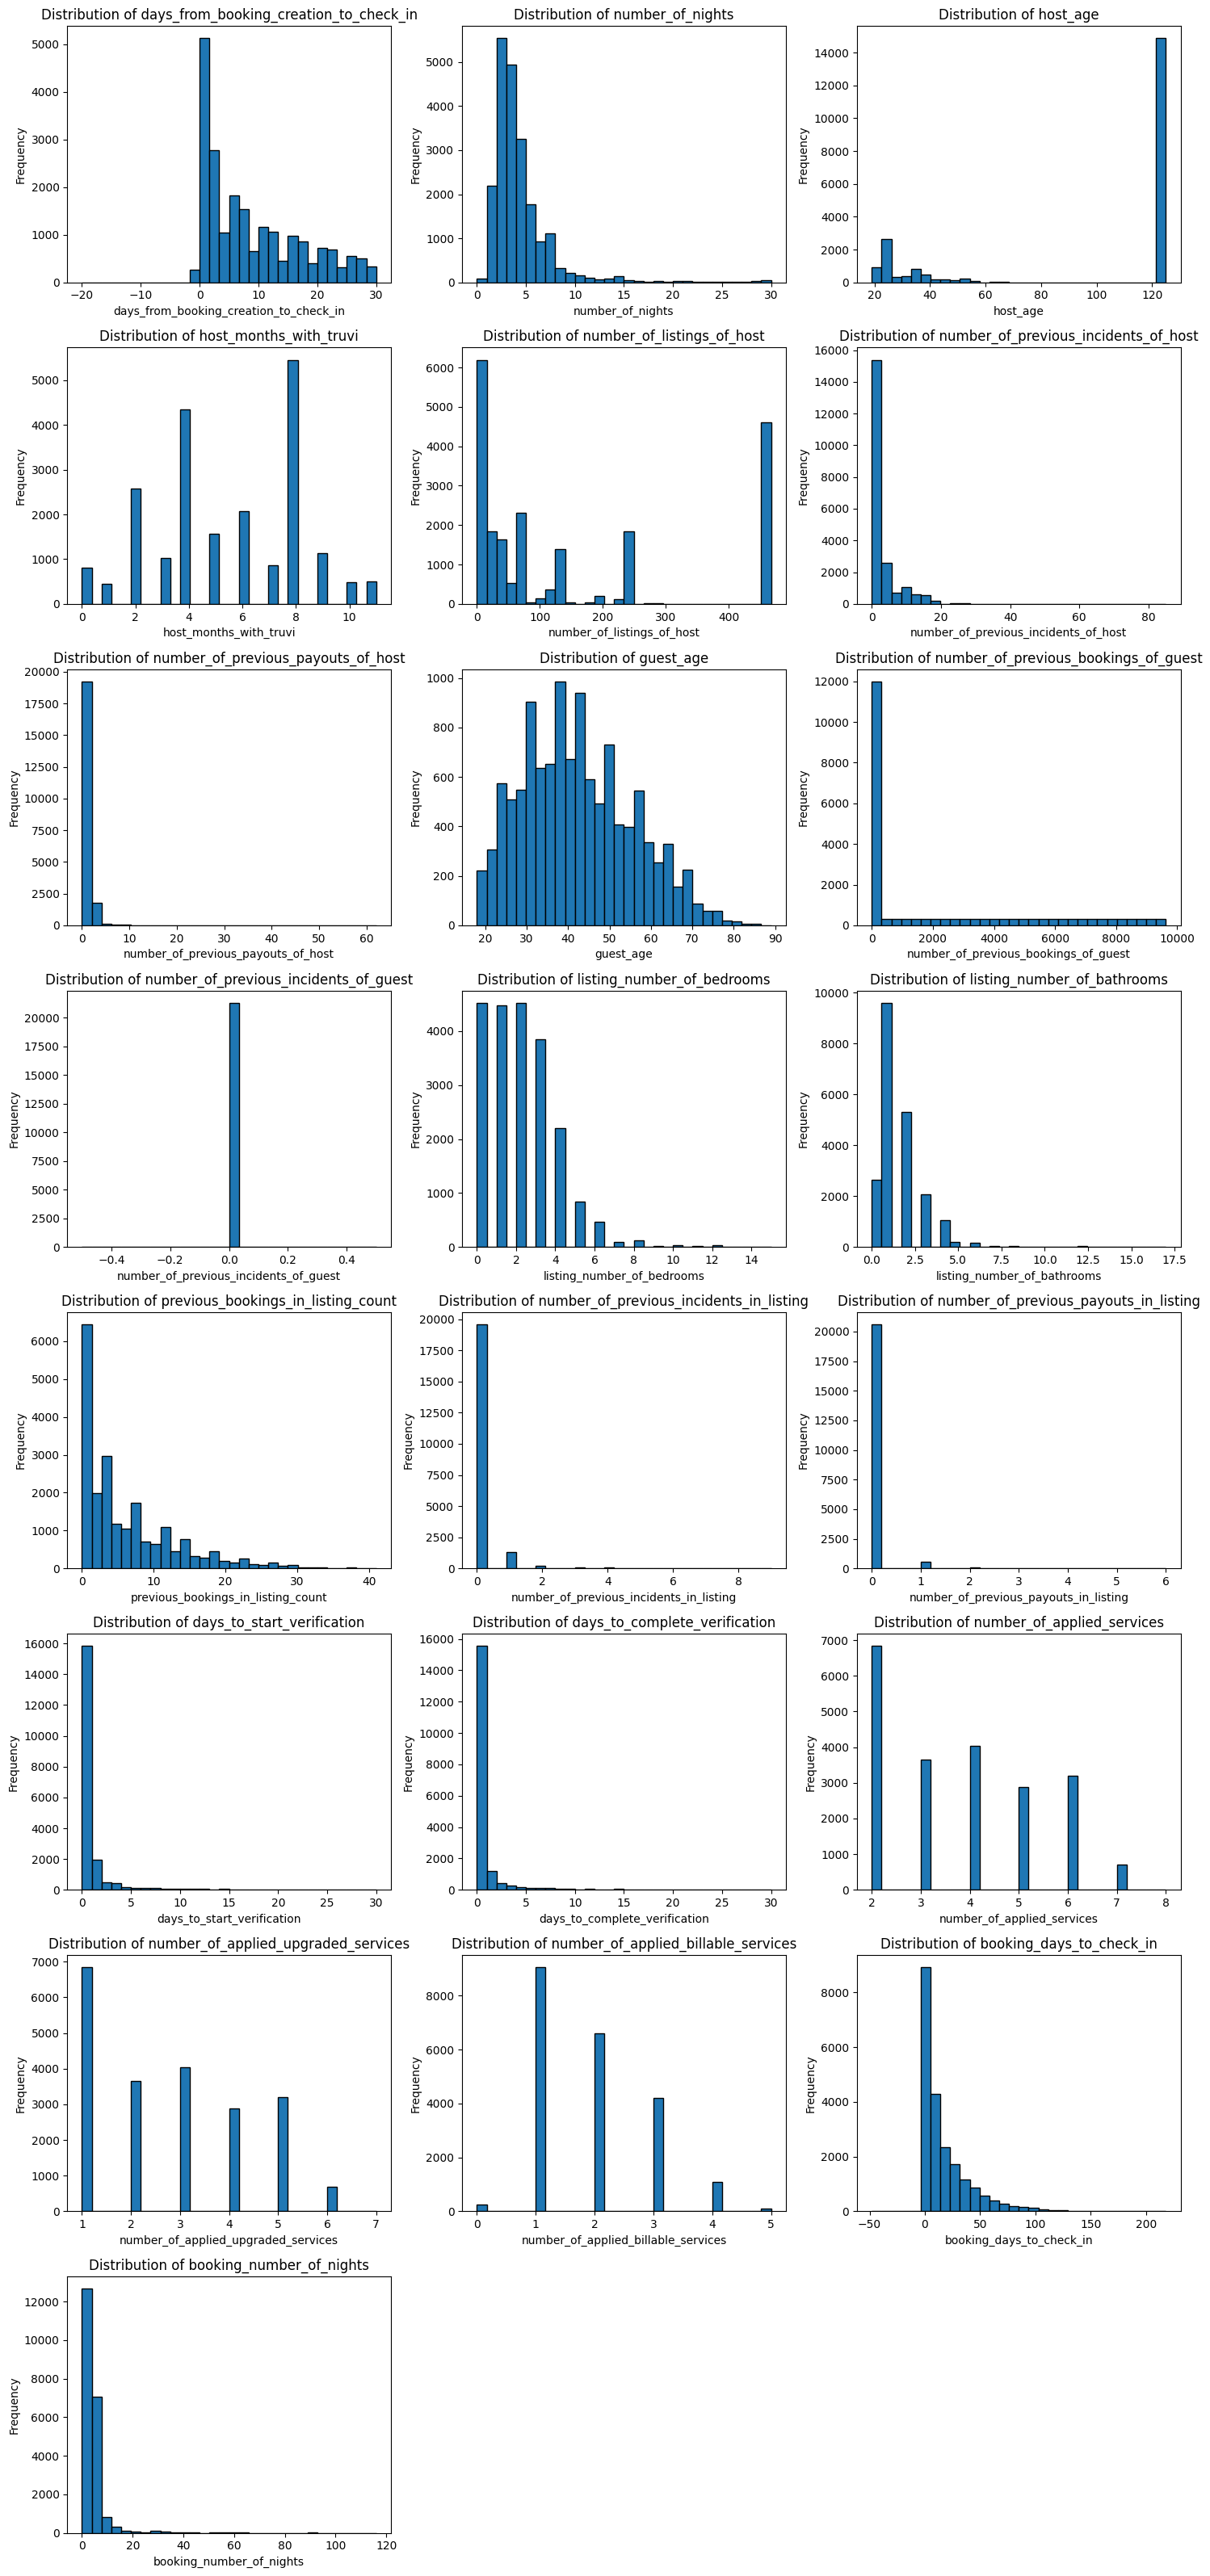

In [85]:
# Select numeric columns
numerical = df.select_dtypes(include='number').columns
n_cols = 3
n_rows = math.ceil(len(numerical) / n_cols)

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()

# Plot each numeric column
for i, col in enumerate(numerical):
    axes[i].hist(df[col].dropna(), bins=30, edgecolor='black')
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In [86]:
# We see that there are some outliers in host_age with ages above 100, we will remove those
df['host_age'] = df['host_age'].where(df['host_age'] <= 100, np.nan)

# We drop number_of_previous_incidents_of_guest as it has only 0 values
df.drop(columns=['number_of_previous_incidents_of_guest'], inplace=True)
numerical = df.select_dtypes(include='number').columns

In [87]:
# Check missing values for the remaining columns
missing_values = df.isnull().mean() * 100
missing_values = missing_values[missing_values > 0].sort_values(ascending=False)
print("Missing Values (%):")
print(missing_values)

Missing Values (%):
host_age                         69.826817
guest_age                        45.196414
days_to_complete_verification    13.174074
days_to_start_verification        5.739898
listing_number_of_bathrooms       0.572582
listing_number_of_bedrooms        0.572582
dtype: float64


In [88]:
# We will fill the remaining missing values with the median for numerical columns
for col in numerical:
    df[col] = df[col].fillna(df[col].median())

In [89]:
# Convert all boolean columns to int
bool_columns = df.select_dtypes(include='bool').columns
for col in bool_columns:
    df[col] = df[col].astype(int)

### Feature Relevance Analysis

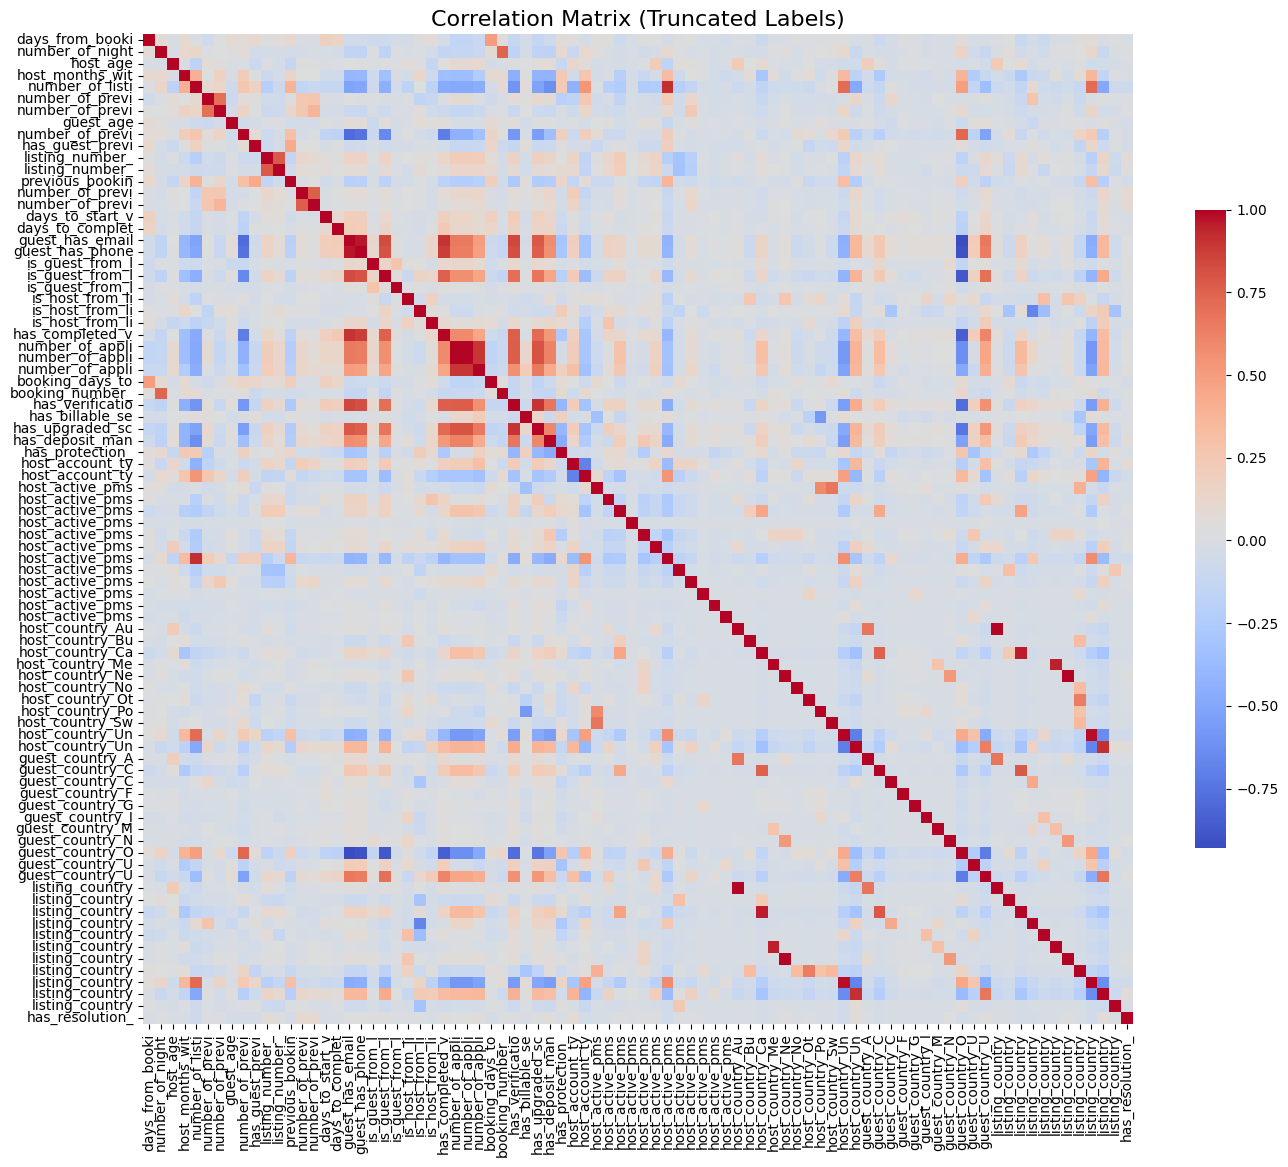

In [90]:
# Check correlation matrix
import seaborn as sns

# 1. Move 'has_resolution_incident' to the end
target_col = 'has_resolution_incident'
if target_col in df.columns:
    columns = [col for col in df.columns if col != target_col] + [target_col]
    df = df[columns]

# 2. Create short column names (truncate to, say, 15 chars)
short_columns = [col[:15] for col in df.columns]

# 3. Compute correlation matrix
correlation_matrix = df.corr()

# 4. Plot with Seaborn
plt.figure(figsize=(14, 12))
sns.heatmap(
    correlation_matrix,
    xticklabels=short_columns,
    yticklabels=short_columns,
    cmap='coolwarm',
    annot=False,
    fmt=".2f",
    square=True,
    cbar_kws={'shrink': 0.6}
)
plt.title('Correlation Matrix (Truncated Labels)', fontsize=16)
plt.tight_layout()
plt.show()


In [91]:
# Compute correlation with the target variable
correlation_with_target = df.corrwith(df['has_resolution_incident'])

# Drop the target itself (its correlation with itself is always 1)
correlation_with_target = correlation_with_target.drop(labels='has_resolution_incident')

# Sort by absolute correlation, descending
correlation_sorted = correlation_with_target.abs().sort_values(ascending=False)

# Print the sorted correlations (you can keep the original signs too if preferred)
print(correlation_sorted)

number_of_previous_incidents_in_listing                0.101702
number_of_previous_payouts_in_listing                  0.096180
host_account_type_Host                                 0.073745
number_of_listings_of_host                             0.070200
listing_number_of_bedrooms                             0.065542
listing_country_United States                          0.062555
host_active_pms_list_Hostify                           0.060898
host_country_United States                             0.055897
has_deposit_management_service_business_type           0.055543
host_country_United Kingdom                            0.049846
listing_country_United Kingdom                         0.048641
guest_country_United States                            0.047742
number_of_applied_billable_services                    0.045234
host_account_type_PMC - Property Management Company    0.044632
has_completed_verification                             0.040583
guest_age                               

### Upsampling Unbalanced Dataset

In [92]:
X = df.drop(columns=['has_resolution_incident'])
y = df['has_resolution_incident']

# 1. Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123, stratify=y)

print("Class distribution in training set BEFORE SMOTE:")
print(y_train.value_counts())

# 2. Apply SMOTE only to the training data
smote = SMOTE(sampling_strategy='auto', random_state=123)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("\nClass distribution in training set AFTER SMOTE:")
print(y_train_resampled.value_counts())

# Now use X_train_resampled, y_train_resampled for model training
# and X_test, y_test for final evaluation.

Class distribution in training set BEFORE SMOTE:
has_resolution_incident
0    16843
1      202
Name: count, dtype: int64

Class distribution in training set AFTER SMOTE:
has_resolution_incident
0    16843
1    16843
Name: count, dtype: int64


### Feature Selection

Since we have many columns, we’ll apply feature selection techniques like KBest, RFE (Recursive Feature Elimination), and Lasso (L1 regularization), to reduce the number of fields used in our predictive model. This helps:
- Avoid overfitting
- Potentially improve model performance (simpler models often generalize better)
- Reduce training time

We'll also experiment with different numbers of features to determine which combination produces the model best suited to our objectives.

In [93]:
selector = SelectKBest(score_func=f_classif, k=30)
X_new = selector.fit_transform(X_train_resampled, y_train_resampled)
selected_features_kbest = X_train_resampled.columns[selector.get_support()]

print("Selected Features:")
print(selected_features_kbest)

Selected Features:
Index(['number_of_listings_of_host', 'guest_age',
       'has_guest_previously_booked_same_listing',
       'listing_number_of_bedrooms', 'listing_number_of_bathrooms',
       'previous_bookings_in_listing_count',
       'number_of_previous_incidents_in_listing',
       'number_of_previous_payouts_in_listing', 'guest_has_email',
       'guest_has_phone_number', 'is_guest_from_listing_country',
       'is_host_from_listing_postcode', 'has_completed_verification',
       'booking_days_to_check_in',
       'has_deposit_management_service_business_type',
       'has_protection_service_business_type', 'host_account_type_Host',
       'host_account_type_PMC - Property Management Company',
       'host_active_pms_list_Guesty', 'host_active_pms_list_Hostify',
       'host_country_Canada', 'host_country_United Kingdom',
       'guest_country_Canada', 'guest_country_Other',
       'guest_country_United Kingdom', 'guest_country_United States',
       'listing_country_Canada', '

In [94]:
# Recursive Feature Elimination (RFE) with Logistic Regression
model = LogisticRegression(max_iter=1000)
rfe = RFE(model, n_features_to_select=30)
rfe.fit(X_train_resampled, y_train_resampled)
selected_features_rfe = X_train_resampled.columns[rfe.support_]

print("Selected Features using RFE:")
print(selected_features_rfe)

/home/joaquin/data-jupyter-notebooks/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/joaquin/data-jupyter-notebooks/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stab

Selected Features using RFE:
Index(['guest_has_email', 'is_guest_from_listing_postcode',
       'is_host_from_listing_postcode', 'has_verification_request',
       'host_active_pms_list_Avantio', 'host_active_pms_list_Guesty',
       'host_active_pms_list_Hospitable Connect',
       'host_active_pms_list_Hostify', 'host_active_pms_list_TrackHs',
       'host_active_pms_list_Uplisting', 'host_country_Canada',
       'host_country_United Kingdom', 'guest_country_Australia',
       'guest_country_Canada', 'guest_country_Colombia',
       'guest_country_France', 'guest_country_Germany',
       'guest_country_Ireland', 'guest_country_Mexico',
       'guest_country_New Zealand', 'guest_country_Other',
       'guest_country_United Kingdom', 'guest_country_United States',
       'listing_country_Australia', 'listing_country_Colombia',
       'listing_country_Ireland', 'listing_country_Mexico',
       'listing_country_Other', 'listing_country_United States',
       'listing_country_Virgin Islan

In [95]:
# Lasso Regression for feature selection
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(penalty='l1', solver='liblinear')
model.fit(X_train_resampled, y_train_resampled)

# Check which features have non-zero coefficients
selected_features_lasso = X_train_resampled.columns[model.coef_[0] != 0]
print("Selected Features using Lasso Regression:")
print(selected_features_lasso)

Selected Features using Lasso Regression:
Index(['days_from_booking_creation_to_check_in', 'number_of_nights',
       'host_age', 'host_months_with_truvi', 'number_of_listings_of_host',
       'number_of_previous_incidents_of_host',
       'number_of_previous_payouts_of_host', 'guest_age',
       'number_of_previous_bookings_of_guest',
       'has_guest_previously_booked_same_listing',
       'listing_number_of_bedrooms', 'listing_number_of_bathrooms',
       'previous_bookings_in_listing_count',
       'number_of_previous_incidents_in_listing',
       'number_of_previous_payouts_in_listing', 'days_to_start_verification',
       'days_to_complete_verification', 'guest_has_email',
       'guest_has_phone_number', 'is_guest_from_listing_town',
       'is_guest_from_listing_country', 'is_guest_from_listing_postcode',
       'is_host_from_listing_town', 'is_host_from_listing_country',
       'is_host_from_listing_postcode', 'has_completed_verification',
       'number_of_applied_services',

## Processing
Processing in this notebook is quite straight-forward: we just drop id booking, split the features and target and apply a scaling to numeric features.
Afterwards, we split the dataset between train and test and display their sizes and target distribution.

In [96]:
# Separate features and target
X_train_kbest = X_train_resampled[selected_features_kbest]  # Use the features selected by SelectKBest
y_train_kbest = y_train_resampled
X_test_kbest = X_test[selected_features_kbest]
y_test_kbest = y_test

# Scale numeric features
X_train_kbest[selected_features_kbest] = X_train_kbest[selected_features_kbest].astype(float)

print(f"Training set size: {X_train_kbest.shape[0]} rows")
print(f"Test set size: {X_test_kbest.shape[0]} rows")

print("\nTraining target distribution:")
print(y_train_kbest.value_counts(normalize=True))

print("\nTest target distribution:")
print(y_test_kbest.value_counts(normalize=True))

Training set size: 33686 rows
Test set size: 4262 rows

Training target distribution:
has_resolution_incident
0    0.5
1    0.5
Name: proportion, dtype: float64

Test target distribution:
has_resolution_incident
0    0.988268
1    0.011732
Name: proportion, dtype: float64


/tmp/ipykernel_51877/1488269494.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_kbest[selected_features_kbest] = X_train_kbest[selected_features_kbest].astype(float)


### Using RFE Features

In [97]:
# Separate features and target
X_train_rfe = X_train_resampled[selected_features_rfe]  # Use the features selected by RFE
y_train_rfe = y_train_resampled
X_test_rfe = X_test[selected_features_rfe]
y_test_rfe = y_test

# Scale numeric features
X_train_rfe[selected_features_rfe] = X_train_rfe[selected_features_rfe].astype(float)

print(f"Training set size: {X_train_rfe.shape[0]} rows")
print(f"Test set size: {X_test_rfe.shape[0]} rows")

print("\nTraining target distribution:")
print(y_train_rfe.value_counts(normalize=True))

print("\nTest target distribution:")
print(y_test_rfe.value_counts(normalize=True))

Training set size: 33686 rows
Test set size: 4262 rows

Training target distribution:
has_resolution_incident
0    0.5
1    0.5
Name: proportion, dtype: float64

Test target distribution:
has_resolution_incident
0    0.988268
1    0.011732
Name: proportion, dtype: float64


/tmp/ipykernel_51877/2037518775.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_rfe[selected_features_rfe] = X_train_rfe[selected_features_rfe].astype(float)


### Using Lasso Features

In [98]:
# Separate features and target
X_train_lasso = X_train_resampled[selected_features_lasso]  # Use the features selected by lasso
y_train_lasso = y_train_resampled
X_test_lasso = X_test[selected_features_lasso]
y_test_lasso = y_test

# Scale numeric features
X_train_lasso[selected_features_lasso] = X_train_lasso[selected_features_lasso].astype(float)

print(f"Training set size: {X_train_lasso.shape[0]} rows")
print(f"Test set size: {X_test_lasso.shape[0]} rows")

print("\nTraining target distribution:")
print(y_train_lasso.value_counts(normalize=True))

print("\nTest target distribution:")
print(y_test_lasso.value_counts(normalize=True))

Training set size: 33686 rows
Test set size: 4262 rows

Training target distribution:
has_resolution_incident
0    0.5
1    0.5
Name: proportion, dtype: float64

Test target distribution:
has_resolution_incident
0    0.988268
1    0.011732
Name: proportion, dtype: float64


/tmp/ipykernel_51877/3979584456.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_lasso[selected_features_lasso] = X_train_lasso[selected_features_lasso].astype(float)


## Classification Model with Random Forest

We define a machine learning pipeline that includes:
- **Scaling numeric features** with `StandardScaler`
- **Training a Random Forest classifier** with balanced class weights to handle the imbalanced dataset

We then use `GridSearchCV` to perform a **grid search with cross-validation** over a range of key hyperparameters (e.g., number of trees, max depth, etc.).  
The model is evaluated using **Average Precision**, which is better suited for imbalanced classification tasks.

The best combination of parameters is selected, and the resulting model is used to make predictions on the test set.


### Model 1 with Kbest Features

In [99]:
# Define pipeline (scaling numeric features only)
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', RandomForestClassifier(class_weight='balanced', # We have an imbalanced dataset
                                     random_state=123))
])

# Define parameter grid
param_grid = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [None, 10, 20],
    'model__min_samples_split': [2, 5],
    'model__min_samples_leaf': [1, 2],
    'model__max_features': ['sqrt', 'log2']
}

# GridSearchCV
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='average_precision',  # For imbalanced classification
    cv=5, # 5-fold cross-validation
    n_jobs=-1, # Use all available cores
    verbose=2 # Verbose output for progress tracking
)

# Fit the grid search on training data
grid_search.fit(X_train_kbest, y_train_kbest)

# Best model
best_pipeline_kbest = grid_search.best_estimator_
print("Best hyperparameters:", grid_search.best_params_)

# Predict on test set
y_pred_proba_kbest = best_pipeline_kbest.predict_proba(X_test_kbest)[:, 1]
y_pred_kbest = best_pipeline_kbest.predict(X_test_kbest)


Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV] END model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100; total time=   7.2s
[CV] END model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100; total time=   7.5s
[CV] END model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100; total time=   7.9s
[CV] END model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100; total time=   8.1s
[CV] END model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100; total time=   8.4s
[CV] END model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100; total time=  10

### Model 2 with RFE Features

In [100]:
# Define pipeline (scaling numeric features only)
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', RandomForestClassifier(class_weight='balanced', # We have an imbalanced dataset
                                     random_state=123))
])

# Define parameter grid
param_grid = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [None, 10, 20],
    'model__min_samples_split': [2, 5],
    'model__min_samples_leaf': [1, 2],
    'model__max_features': ['sqrt', 'log2']
}

# GridSearchCV
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='average_precision',  # For imbalanced classification
    cv=5, # 5-fold cross-validation
    n_jobs=-1, # Use all available cores
    verbose=2 # Verbose output for progress tracking
)

# Fit the grid search on training data
grid_search.fit(X_train_rfe, y_train_rfe)

# Best model
best_pipeline_rfe = grid_search.best_estimator_
print("Best hyperparameters:", grid_search.best_params_)

# Predict on test set
y_pred_proba_rfe = best_pipeline_rfe.predict_proba(X_test_rfe)[:, 1]
y_pred_rfe = best_pipeline_rfe.predict(X_test_rfe)


Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV] END model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100; total time=   3.5s
[CV] END model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100; total time=   3.5s
[CV] END model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100; total time=   3.6s
[CV] END model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100; total time=   3.8s
[CV] END model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100; total time=   3.4s
[CV] END model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100; total time=   4

### Model 3 with Lasso Features

In [101]:
# Define pipeline (scaling numeric features only)
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', RandomForestClassifier(class_weight='balanced', # We have an imbalanced dataset
                                     random_state=123))
])

# Define parameter grid
param_grid = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [None, 10, 20],
    'model__min_samples_split': [2, 5],
    'model__min_samples_leaf': [1, 2],
    'model__max_features': ['sqrt', 'log2']
}

# GridSearchCV
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='average_precision',  # For imbalanced classification
    cv=5, # 5-fold cross-validation
    n_jobs=-1, # Use all available cores
    verbose=2 # Verbose output for progress tracking
)

# Fit the grid search on training data
grid_search.fit(X_train_lasso, y_train_lasso)

# Best model
best_pipeline_lasso = grid_search.best_estimator_
print("Best hyperparameters:", grid_search.best_params_)

# Predict on test set
y_pred_proba_lasso = best_pipeline_lasso.predict_proba(X_test_lasso)[:, 1]
y_pred_lasso = best_pipeline_lasso.predict(X_test_lasso)


Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV] END model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100; total time=   8.4s
[CV] END model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100; total time=   9.0s
[CV] END model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100; total time=   9.8s
[CV] END model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100; total time=  10.2s
[CV] END model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100; total time=   8.5s
[CV] END model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100; total time=  10

## Evaluation
This section aims to evaluate how good the new model is vs. the actual Resolution Incidents.

We start by computing and displaying the classification report, ROC Curve, PR Curve and the respective Area Under the Curve (AUC).

### Model 1 evaluation

In [102]:
# Actual and predicted
y_true_kbest = y_test_kbest

# Compute confusion matrix: [ [TN, FP], [FN, TP] ]
tn, fp, fn, tp = confusion_matrix(y_true_kbest, y_pred_kbest).ravel()

# Total predictions
total = tp + tn + fp + fn

# Compute all requested metrics
recall_kbest = recall_score(y_true_kbest, y_pred_kbest)
precision_kbest = precision_score(y_true_kbest, y_pred_kbest)
f1_kbest = fbeta_score(y_true_kbest, y_pred_kbest, beta=1)
f2_kbest = fbeta_score(y_true_kbest, y_pred_kbest, beta=2)
fpr_kbest = fp / (fp + tn) if (fp + tn) != 0 else 0

# Scores relative to total
tp_score_kbest = tp / total
tn_score_kbest = tn / total
fp_score_kbest = fp / total
fn_score_kbest = fn / total

# Create DataFrame
summary_df_kbest = pd.DataFrame([{
    "title": "Kbest",
    "flagging_analysis_type": "RISK_VS_CLAIM using KBest Features from all features",
    "count_total": total,
    "count_true_positive": tp,
    "count_true_negative": tn,
    "count_false_positive": fp,
    "count_false_negative": fn,
    "true_positive_score": tp_score_kbest,
    "true_negative_score": tn_score_kbest,
    "false_positive_score": fp_score_kbest,
    "false_negative_score": fn_score_kbest,
    "recall_score": recall_kbest,
    "precision_score": precision_kbest,
    "false_positive_rate_score": fpr_kbest,
    "f1_score": f1_kbest,
    "f2_score": f2_kbest
}])

### Model 2 evaluation

In [103]:
# Actual and predicted
y_true_rfe = y_test_rfe

# Compute confusion matrix: [ [TN, FP], [FN, TP] ]
tn, fp, fn, tp = confusion_matrix(y_true_rfe, y_pred_rfe).ravel()

# Total predictions
total = tp + tn + fp + fn

# Compute all requested metrics
recall_rfe = recall_score(y_true_rfe, y_pred_rfe)
precision_rfe = precision_score(y_true_rfe, y_pred_rfe)
f1_rfe = fbeta_score(y_true_rfe, y_pred_rfe, beta=1)
f2_rfe = fbeta_score(y_true_rfe, y_pred_rfe, beta=2)
fpr_rfe = fp / (fp + tn) if (fp + tn) != 0 else 0

# Scores relative to total
tp_score_rfe = tp / total
tn_score_rfe = tn / total
fp_score_rfe = fp / total
fn_score_rfe = fn / total

# Create DataFrame
summary_df_rfe = pd.DataFrame([{
    "title": "RFE",
    "flagging_analysis_type": "RISK_VS_CLAIM using RFE Features from all features",
    "count_total": total,
    "count_true_positive": tp,
    "count_true_negative": tn,
    "count_false_positive": fp,
    "count_false_negative": fn,
    "true_positive_score": tp_score_rfe,
    "true_negative_score": tn_score_rfe,
    "false_positive_score": fp_score_rfe,
    "false_negative_score": fn_score_rfe,
    "recall_score": recall_rfe,
    "precision_score": precision_rfe,
    "false_positive_rate_score": fpr_rfe,
    "f1_score": f1_rfe,
    "f2_score": f2_rfe
}])

### Model 3 evaluation

In [104]:
# Actual and predicted
y_true_lasso = y_test_lasso

# Compute confusion matrix: [ [TN, FP], [FN, TP] ]
tn, fp, fn, tp = confusion_matrix(y_true_lasso, y_pred_lasso).ravel()

# Total predictions
total = tp + tn + fp + fn

# Compute all requested metrics
recall_lasso = recall_score(y_true_lasso, y_pred_lasso)
precision_lasso = precision_score(y_true_lasso, y_pred_lasso)
f1_lasso = fbeta_score(y_true_lasso, y_pred_lasso, beta=1)
f2_lasso = fbeta_score(y_true_lasso, y_pred_lasso, beta=2)
fpr_lasso = fp / (fp + tn) if (fp + tn) != 0 else 0

# Scores relative to total
tp_score_lasso = tp / total
tn_score_lasso = tn / total
fp_score_lasso = fp / total
fn_score_lasso = fn / total

# Create DataFrame
summary_df_lasso = pd.DataFrame([{
    "title": "Lasso",
    "flagging_analysis_type": "RISK_VS_CLAIM using Lasso Features from all features",
    "count_total": total,
    "count_true_positive": tp,
    "count_true_negative": tn,
    "count_false_positive": fp,
    "count_false_negative": fn,
    "true_positive_score": tp_score_lasso,
    "true_negative_score": tn_score_lasso,
    "false_positive_score": fp_score_lasso,
    "false_negative_score": fn_score_lasso,
    "recall_score": recall_lasso,
    "precision_score": precision_lasso,
    "false_positive_rate_score": fpr_lasso,
    "f1_score": f1_lasso,
    "f2_score": f2_lasso
}])

In [105]:
def plot_confusion_matrix_from_df(df, flagging_analysis_type):

    # Subset - just retrieve one row depending on the flagging_analysis_type
    row = df[df['flagging_analysis_type'] == flagging_analysis_type].iloc[0]

    # Define custom x-axis labels and wording
    if flagging_analysis_type == 'RISK_VS_CLAIM':
        x_labels = ['With Submitted Claim', 'Without Submitted Claim']
        outcome_label = "submitted claim"
    elif flagging_analysis_type == 'RISK_VS_SUBMITTED_PAYOUT':
        x_labels = ['With Submitted Payout', 'Without Submitted Payout']
        outcome_label = "submitted payout"
    else:
        x_labels = ['Actual Positive', 'Actual Negative']  
        outcome_label = "outcome"

    # Confusion matrix structure
    cm = np.array([
        [row['count_true_positive'], row['count_false_positive']],
        [row['count_false_negative'], row['count_true_negative']]
    ])

    # Create annotations for the confusion matrix
    labels = [['True Positives', 'False Positives'], ['False Negatives', 'True Negatives']]
    counts = [[f"{v:,}" for v in [row['count_true_positive'], row['count_false_positive']]],
              [f"{v:,}" for v in [row['count_false_negative'], row['count_true_negative']]]]
    percentages = [[f"{round(100*v,2):,}" for v in [row['true_positive_score'], row['false_positive_score']]],
                   [f"{round(100*v,2):,}" for v in [row['false_negative_score'], row['true_negative_score']]]]
    annot = [[f"{labels[i][j]}\n{counts[i][j]} ({percentages[i][j]}%)" for j in range(2)] for i in range(2)]

    # Scores formatted as percentages
    recall = row['recall_score'] * 100
    precision = row['precision_score'] * 100
    f1 = row['f1_score'] * 100
    f2 = row['f2_score'] * 100

    # Set up figure and axes manually for precise control
    fig = plt.figure(figsize=(9, 8))
    grid = fig.add_gridspec(nrows=4, height_ratios=[2, 2, 15, 2])

    
    ax_main_title = fig.add_subplot(grid[0])
    ax_main_title.axis('off')
    ax_main_title.set_title(f"Random Predictor - Flagged as Risk vs. {outcome_label.title()}", fontsize=14, weight='bold')
    
    # Business explanation text
    ax_text = fig.add_subplot(grid[1])
    ax_text.axis('off')
    business_text = (
        f"Flagging performance analysis:\n\n"
        f"- Of all the bookings we flagged as at Risk, {precision:.2f}% actually turned into a {outcome_label}.\n"
        f"- Of all the bookings that resulted in a {outcome_label}, we correctly flagged {recall:.2f}% of them.\n"
        f"- The pure balance between these two is summarized by a score of {f1:.2f}%.\n"
        f"- If we prioritise better probability of detection of a {outcome_label}, the balanced score is {f2:.2f}%.\n"
    )
    ax_text.text(0.0, 0.0, business_text, fontsize=10.5, ha='left', va='bottom', wrap=False, linespacing=1.5)

    # Heatmap
    ax_heatmap = fig.add_subplot(grid[2])
    ax_heatmap.set_title(f"Confusion Matrix – Risk vs. {outcome_label.title()}", fontsize=12, weight='bold', ha='center', va='center', wrap=False)

    cmap = sns.light_palette("#315584", as_cmap=True)

    sns.heatmap(cm, annot=annot, fmt='', cmap=cmap, cbar=False,
                xticklabels=x_labels,
                yticklabels=['Flagged as Risk', 'Flagged as No Risk'],
                ax=ax_heatmap,
                linewidths=1.0,
                annot_kws={'fontsize': 10, 'linespacing': 1.2})
    ax_heatmap.set_xlabel("Resolution Outcome (Actual)", fontsize=11, labelpad=10)
    ax_heatmap.set_ylabel("Flagging (Prediction)", fontsize=11, labelpad=10)
    
    # Make borders visible
    for _, spine in ax_heatmap.spines.items():
        spine.set_visible(True)

    # Footer with metrics and date
    ax_footer = fig.add_subplot(grid[3])
    ax_footer.axis('off')
    metrics_text = f"Total Booking Count: {row['count_total']}   |   Recall: {recall:.2f}%   |   Precision: {precision:.2f}%   |   F1 Score: {f1:.2f}%   |   F2 Score: {f2:.2f}%"
    date_text = f"Generated on {date.today().strftime('%B %d, %Y')}"
    ax_footer.text(0.5, 0.7, metrics_text, ha='center', fontsize=9)
    ax_footer.text(0.5, 0.1, date_text, ha='center', fontsize=8, color='gray')

    plt.tight_layout()
    plt.show()

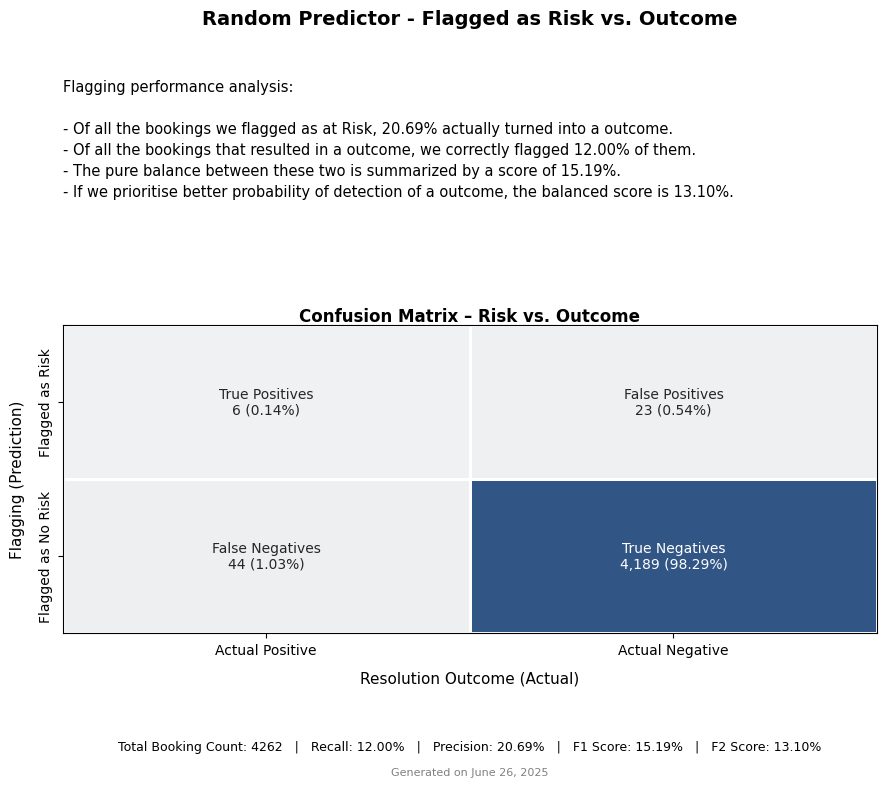

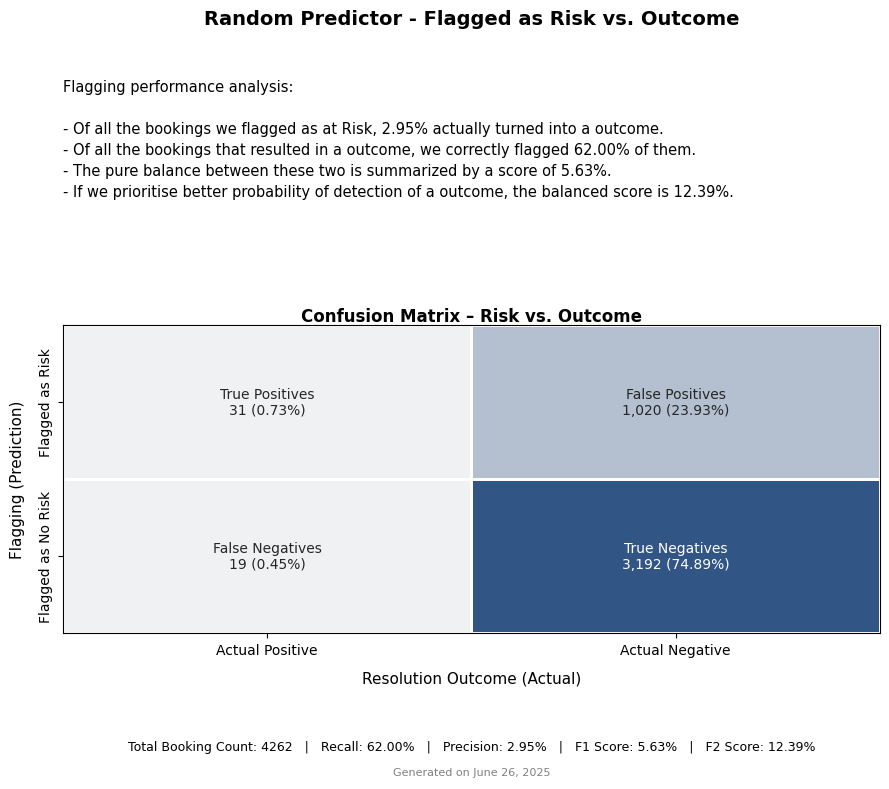

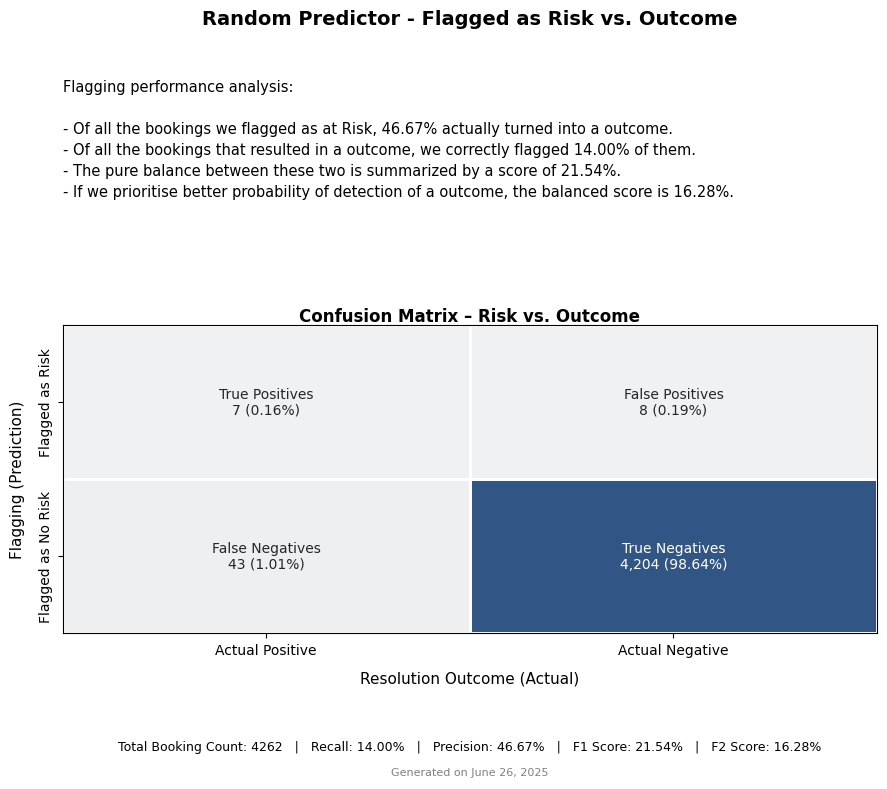

In [106]:
# Plot confusion matrix for claim scenario
plot_confusion_matrix_from_df(summary_df_kbest, 'RISK_VS_CLAIM using KBest Features from all features')
plot_confusion_matrix_from_df(summary_df_rfe, 'RISK_VS_CLAIM using RFE Features from all features')
plot_confusion_matrix_from_df(summary_df_lasso, 'RISK_VS_CLAIM using Lasso Features from all features')

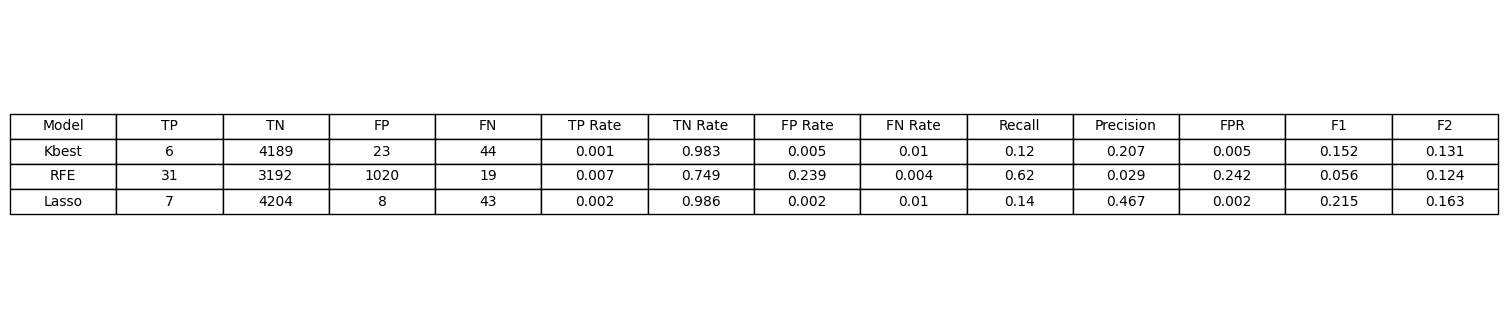

In [107]:
# Print a table to summarize the results
summary_table = pd.concat([summary_df_kbest, summary_df_rfe, summary_df_lasso], ignore_index=True)
summary_table = summary_table[['title', 'count_true_positive', 'count_true_negative',
                               'count_false_positive', 'count_false_negative', 'true_positive_score', 'true_negative_score',
                               'false_positive_score', 'false_negative_score', 'recall_score', 'precision_score',
                               'false_positive_rate_score', 'f1_score', 'f2_score']]

# Rename them
summary_table.columns = ['Model', 'TP', 'TN', 'FP', 'FN',
                         'TP Rate', 'TN Rate', 'FP Rate', 'FN Rate',
                         'Recall', 'Precision', 'FPR', 'F1', 'F2']
                         
# summary_table.to_csv('flagging_analysis_summary.csv', index=False)
import matplotlib.pyplot as plt

# Set up figure and axis
fig, ax = plt.subplots(figsize=(16, 4))  # Adjust width/height as needed
ax.axis('off')  # Hide axes

# Create table from DataFrame
table = ax.table(cellText=summary_table.round(3).values,
                 colLabels=summary_table.columns,
                 loc='center',
                 cellLoc='center')

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.5)  # Adjust cell size

# Save as image
plt.show()

### Interpreting the Classification Report

The **Classification Report** provides key metrics to evaluate how well the model performed on each class.

It includes the following metrics for each class (0 and 1):
* Metric: Meaning
* Precision: Out of all predicted positives, how many were actually positive?
* Recall: Out of all actual positives, how many did we correctly identify?
* F1-score: Harmonic mean of precision and recall (balances both)
* Support: Number of true samples of that class in the test data

Interpretation:
* Class 0 = No incident
* Class 1 = Has resolution incident (rare, but important!)

A few explanatory cases:
* A high recall for class 1 means we're catching most incidents.
* A high precision for class 1 means when we predict an incident, we're often correct.
* The F1-score gives a single balanced measure (good for imbalanced data).

Special note for imbalanced data:
Since class 1 (or just True) is rare (1% in our case), metrics for that class are more critical.
We want to maximize recall to catch as many real incidents as possible — without letting precision drop too low (to avoid too many false alarms).

### Results Summary

- Model 1 (KBest) offers a low recall (12%) and precision (20.7%), but keeps the false positives very low, indicating a conservative model.
- Model 2 (RFE) achieves high recall (62%) but at the cost of extremely low precision (2.9%) and high false positives, meaning it's flagging many non-incident bookings incorrectly.
- Model 3 (Lasso) provides the best balance between recall and precision, resulting in the highest F1 (21.5%) and F2 (16.3%), with low false positive rate (0.2%).

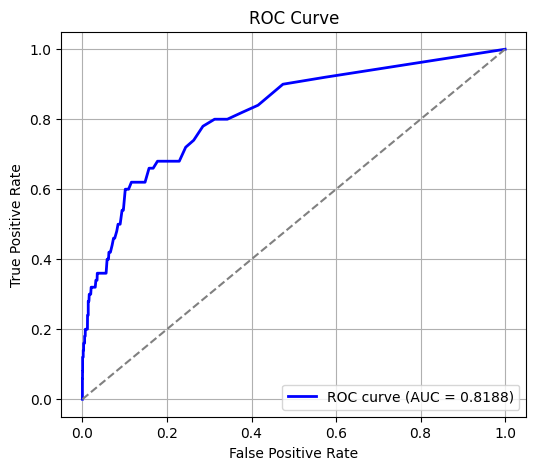

In [108]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test_lasso, y_pred_proba_lasso)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

### Interpreting the ROC Curve

The **Receiver Operating Characteristic (ROC) curve** shows how well the model distinguishes between the positive and negative classes across all decision thresholds.

A quick reminder of the definitions:
* True Positive Rate (TPR) = Recall
* False Positive Rate (FPR) = Proportion of negatives wrongly classified as positives

What we display in this plot is:
* The x-axis is False Positive Rate
* The y-axis is True Positive Rate

The curve shows how TPR and FPR change as the threshold varies

It's important to note that:
* A model with no skill will produce a diagonal line (AUC = 0.5)
* A model with perfect discrimination will hug the top-left corner (AUC = 1.0)

The Area Under the Curve (ROC AUC) gives a single performance score:
* Closer to 1 means better at ranking positive cases higher than negative ones

**Important!**

While useful, the ROC curve can sometimes overestimate performance when the dataset is imbalanced, because it includes negatives (which dominate in our case, around 99%!). That’s why we also MUST check the Precision-Recall curve.

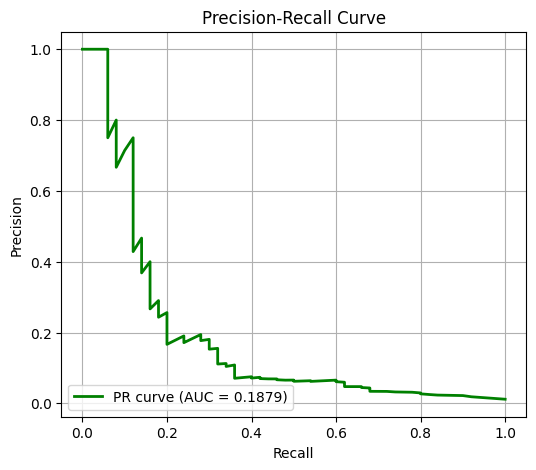

In [109]:
# PR Curve
precision, recall, _ = precision_recall_curve(y_test_lasso, y_pred_proba_lasso)
pr_auc = average_precision_score(y_test_lasso, y_pred_proba_lasso)

plt.figure(figsize=(6, 5))
plt.plot(recall, precision, color='green', lw=2, label=f'PR curve (AUC = {pr_auc:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

### Interpreting the Precision-Recall (PR) Curve

The **Precision-Recall (PR) curve** helps evaluate model performance, especially on imbalanced datasets like ours (where positive cases are rare).

A quick reminder of the definitions:
* Precision = How many of the predicted positives are actually positive
* Recall = How many of the actual positives the model correctly identifies

What we display in this plot is:
* The x-axis is Recall 
* The y-axis is Precision 

The curve shows the trade-off between them at different model thresholds

In imbalanced datasets, accuracy can be misleading — the PR curve focuses only on the positive class, making it much more meaningful:
* A higher curve means better performance
* The area under the curve (PR AUC) summarizes this: closer to 1 is better

## Feature Importance
Understanding what drives the prediction is useful for future experiments and business knowledge. Here we track both the native feature importances of the trees, as well as a more heavy SHAP values analysis.

Important! Be aware that SHAP analysis might take quite a bit of time.

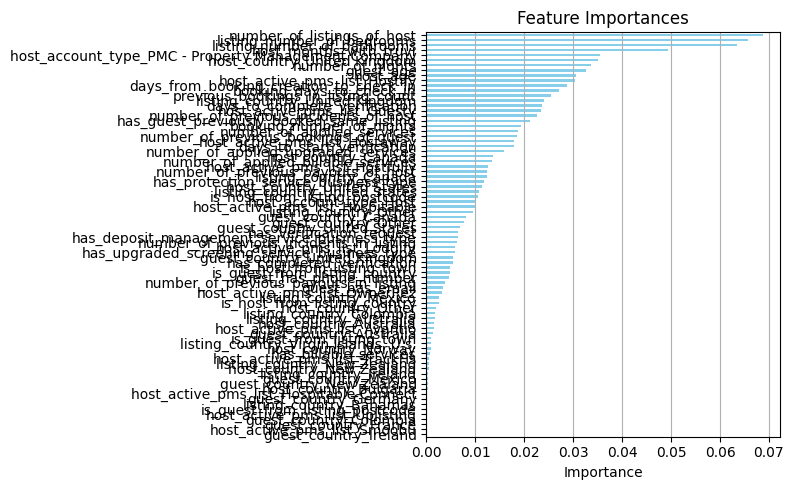

In [110]:
## BUILT-IN

# Get feature importances from the model
importances = best_pipeline_lasso.named_steps['model'].feature_importances_

# Create a Series and sort
feat_series = pd.Series(importances, index=selected_features_lasso).sort_values(ascending=True)  # ascending=True for horizontal plot

# Plot Feature Importances
plt.figure(figsize=(8, 5))
feat_series.plot(kind='barh', color='skyblue')
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.grid(axis='x')
plt.tight_layout()
plt.show()

### Interpreting the Feature Importance Plot
The **feature importance plot** shows how much each feature contributes to the model’s overall decision-making.

For tree-based models like Random Forest, importance is based on how often and how effectively a feature is used to split the data across all trees.
A higher score means the feature plays a bigger role in improving prediction accuracy.

In the graph you will see that:
* Features are ranked from most to least important.
* The values are relative and model-specific — not directly interpretable as weights or probabilities.

This helps us identify which features the model relies on most when making predictions.

**Important!**
Unlike SHAP values, native importance doesn't show how a feature affects predictions — only how useful it is to the model overall. For deeper interpretability (e.g., direction and context), SHAP is better (but it takes more time to run).

PermutationExplainer explainer: 4263it [22:09,  3.21it/s]                          
/tmp/ipykernel_51877/2010823018.py:21: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values.values, X_test_shap)


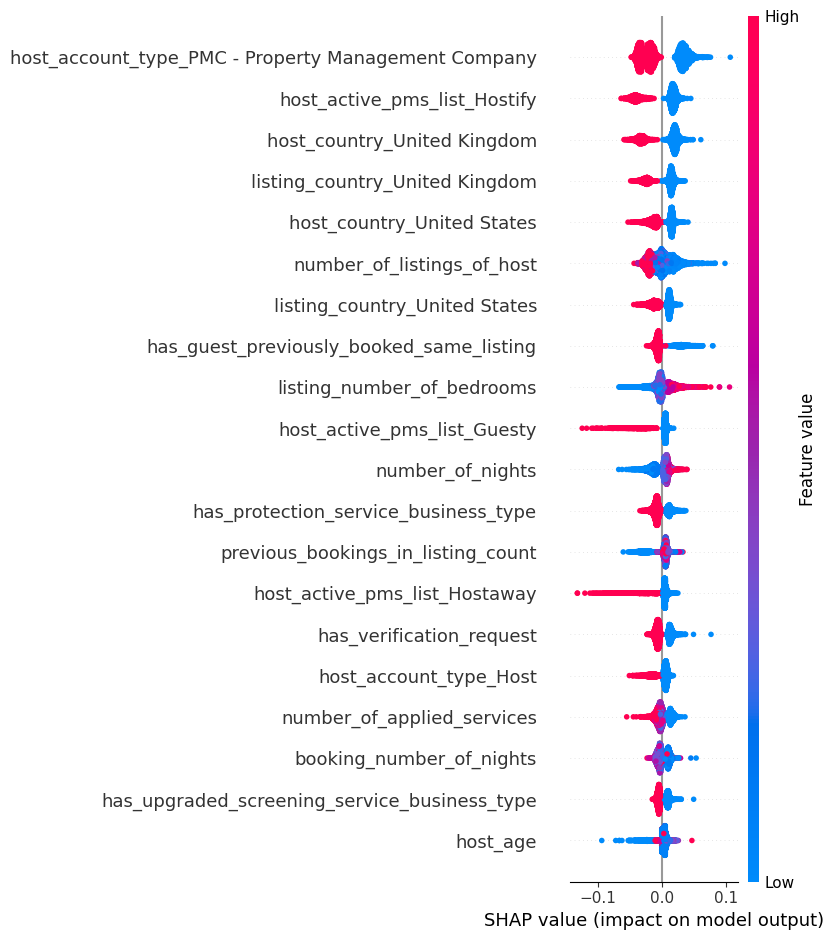

In [111]:
## SHAP VALUES

# SHAP requires that all features passed to Explainer be numeric (floats/ints)
X_test_shap = X_test_lasso.copy()
X_test_shap = X_test_shap.astype(float)

# Function that returns the probability of the positive class
def model_predict(data):
    return best_pipeline_lasso.predict_proba(data)[:, 1]

# Ensure input to SHAP is numeric
X_test_shap = X_test_lasso.astype(float)

# Create SHAP explainer
explainer = shap.Explainer(model_predict, X_test_shap)

# Compute SHAP values
shap_values = explainer(X_test_shap)

# Plot summary
shap.summary_plot(shap_values.values, X_test_shap)

### Interpreting the SHAP Summary Plot

Each point on a row represents a SHAP value for a single prediction (row = feature).
The x-axis shows how much the feature contributed to increasing or decreasing the prediction.
* Right (positive SHAP value): pushes prediction toward the positive class (i.e., higher chance of incident).
* Left (negative SHAP value): pushes prediction toward the negative class (i.e., lower chance of incident).

Color shows the actual feature value for that point:
* Red = high value
* Blue = low value

In other words:
* The position tells you impact.
* The color tells you feature value.
* The density (thickness) of dots shows how often a value occurs.

In [112]:
import re

def clean_colname(col):
    return re.sub(r'[^A-Za-z0-9_]+', '_', col)

X_train_lasso.columns = [clean_colname(col) for col in X_train_lasso.columns]
X_test_lasso.columns = X_train_lasso.columns  # Keep them aligned

In [113]:
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import ExtraTreesClassifier

# Updated model list
models = {
    "Random Forest": RandomForestClassifier(class_weight='balanced', random_state=123),
    "XGBoost": XGBClassifier(scale_pos_weight=(y_train_lasso.value_counts()[0] / y_train_lasso.value_counts()[1]),
                             use_label_encoder=False, eval_metric='logloss', random_state=123),
    "LightGBM": LGBMClassifier(class_weight='balanced', random_state=123),
    "Extra Trees": ExtraTreesClassifier(class_weight='balanced', random_state=123)
}

results = {}

for name, model in models.items():
    pipeline = Pipeline([
        ('classifier', model)
    ])

    pipeline.fit(X_train_lasso, y_train_lasso)
    y_pred_proba = pipeline.predict_proba(X_test_lasso)[:, 1]

    avg_precision = average_precision_score(y_test_lasso, y_pred_proba)
    results[name] = avg_precision

# Sort and display
sorted_results = dict(sorted(results.items(), key=lambda x: x[1], reverse=True))
for model, score in sorted_results.items():
    print(f"{model}: Average Precision = {score:.4f}")

/home/joaquin/data-jupyter-notebooks/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:47:04] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Number of positive: 16843, number of negative: 16843
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002913 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3256
[LightGBM] [Info] Number of data points in the train set: 33686, number of used features: 78
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Random Forest: Average Precision = 0.2043
Extra Trees: Average Precision = 0.1996
XGBoost: Average Precision = 0.1267
LightGBM: Average Precision = 0.0924


### Model 4 Extra Trees Classifier with Lasso features

In [114]:
# Define pipeline (scaling numeric features only)
et_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', ExtraTreesClassifier(class_weight='balanced', random_state=123))
])

# Define parameter grid for ExtraTrees
et_param_grid = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [None, 10, 20],
    'model__min_samples_split': [2, 5],
    'model__min_samples_leaf': [1, 2],
    'model__max_features': ['sqrt', 'log2']
}

# GridSearchCV
et_grid_search = GridSearchCV(
    estimator=et_pipeline,
    param_grid=et_param_grid,
    scoring='average_precision',  # For imbalanced classification
    cv=5,
    n_jobs=-1,
    verbose=2
)

# Fit the grid search on training data
et_grid_search.fit(X_train_lasso, y_train_lasso)

# Best model
best_et_pipeline_lasso = et_grid_search.best_estimator_
print("Best hyperparameters (Extra Trees):", et_grid_search.best_params_)

# Predict on test set
y_pred_proba_et_lasso = best_et_pipeline_lasso.predict_proba(X_test_lasso)[:, 1]
y_pred_et_lasso = best_et_pipeline_lasso.predict(X_test_lasso)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV] END model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100; total time=   8.0s
[CV] END model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100; total time=   8.6s
[CV] END model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100; total time=   8.6s
[CV] END model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100; total time=   8.7s
[CV] END model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100; total time=   8.2s
[CV] END model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100; total time=  10

In [127]:
# Actual and predicted
y_true_et_lasso = y_test_lasso

# Compute confusion matrix: [ [TN, FP], [FN, TP] ]
tn, fp, fn, tp = confusion_matrix(y_true_et_lasso, y_pred_et_lasso).ravel()

# Total predictions
total = tp + tn + fp + fn

# Compute all requested metrics
recall_et_lasso = recall_score(y_true_et_lasso, y_pred_et_lasso)
precision_et_lasso = precision_score(y_true_et_lasso, y_pred_et_lasso)
f1_et_lasso = fbeta_score(y_true_et_lasso, y_pred_et_lasso, beta=1)
f2_et_lasso = fbeta_score(y_true_et_lasso, y_pred_et_lasso, beta=2)
fpr_et_lasso = fp / (fp + tn) if (fp + tn) != 0 else 0

# Scores relative to total
tp_score_et_lasso = tp / total
tn_score_et_lasso = tn / total
fp_score_et_lasso = fp / total
fn_score_et_lasso = fn / total

# Create DataFrame
summary_df_et_lasso = pd.DataFrame([{
    "title": "Lasso ET",
    "flagging_analysis_type": "RISK_VS_CLAIM using Extra Trees with Lasso Features",
    "count_total": total,
    "count_true_positive": tp,
    "count_true_negative": tn,
    "count_false_positive": fp,
    "count_false_negative": fn,
    "true_positive_score": tp_score_et_lasso,
    "true_negative_score": tn_score_et_lasso,
    "false_positive_score": fp_score_et_lasso,
    "false_negative_score": fn_score_et_lasso,
    "recall_score": recall_et_lasso,
    "precision_score": precision_et_lasso,
    "false_positive_rate_score": fpr_et_lasso,
    "f1_score": f1_et_lasso,
    "f2_score": f2_et_lasso
}])

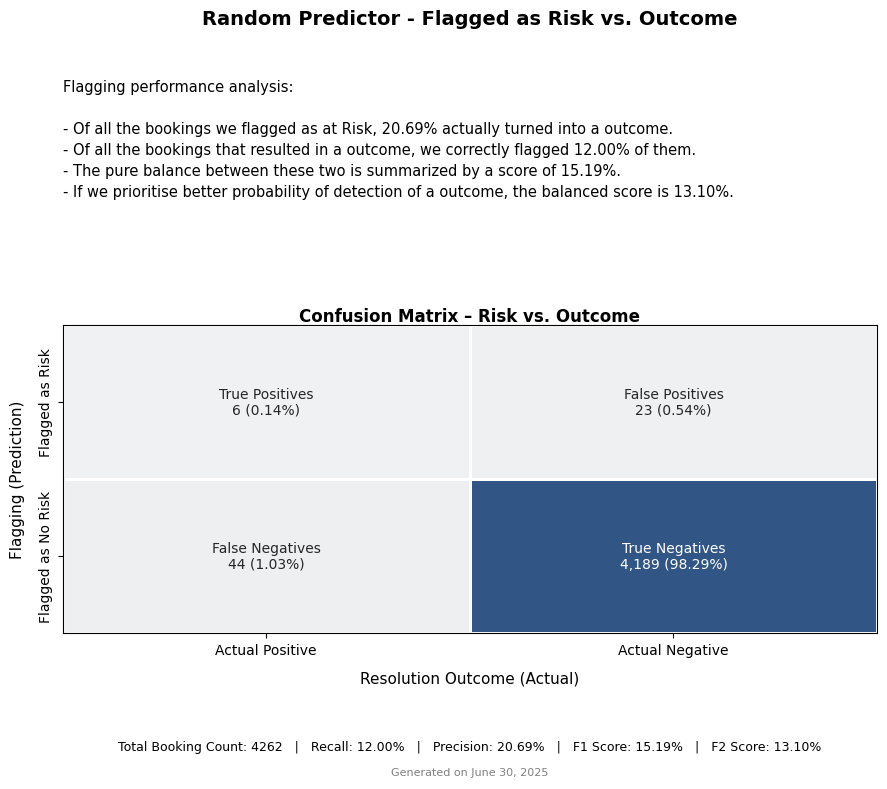

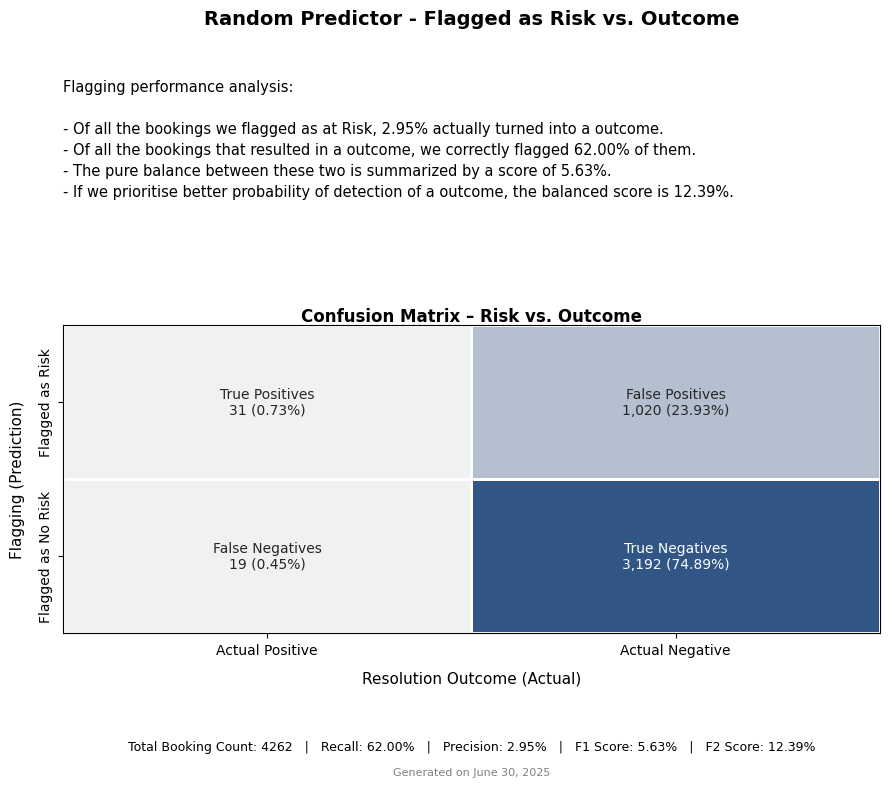

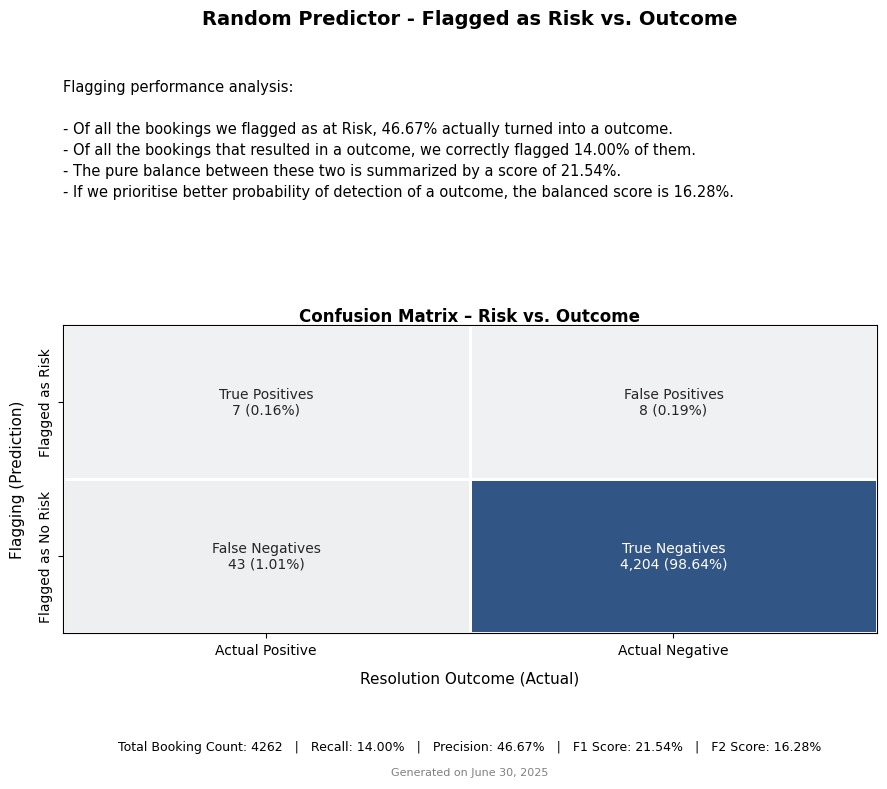

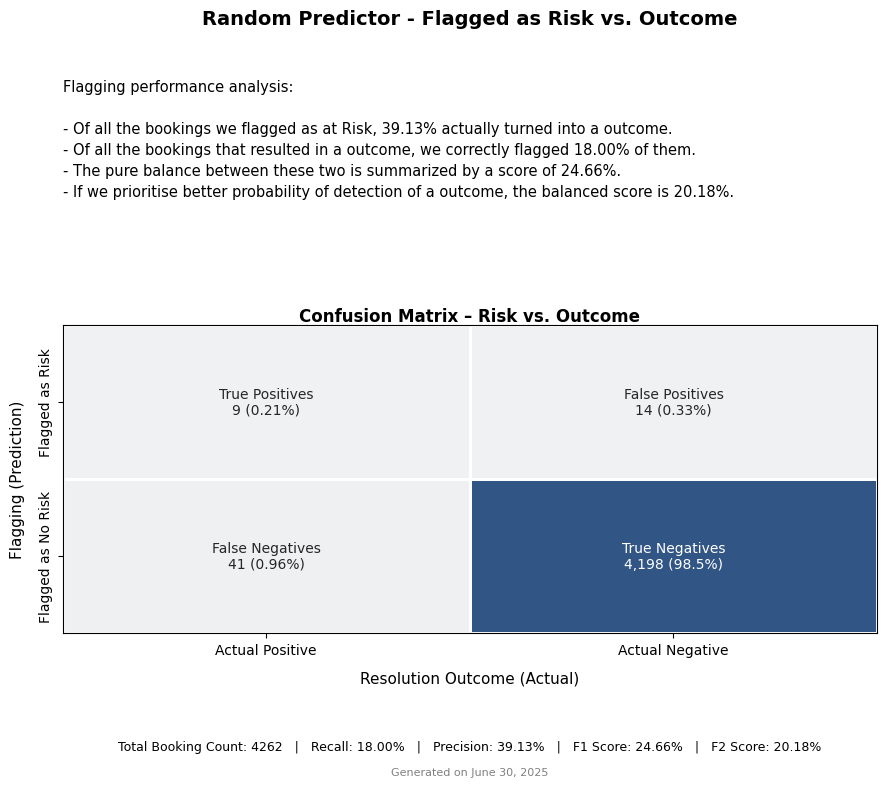

In [128]:
plot_confusion_matrix_from_df(summary_df_kbest, 'RISK_VS_CLAIM using KBest Features from all features')
plot_confusion_matrix_from_df(summary_df_rfe, 'RISK_VS_CLAIM using RFE Features from all features')
plot_confusion_matrix_from_df(summary_df_lasso, 'RISK_VS_CLAIM using Lasso Features from all features')
plot_confusion_matrix_from_df(summary_df_et_lasso, 'RISK_VS_CLAIM using Extra Trees with Lasso Features')

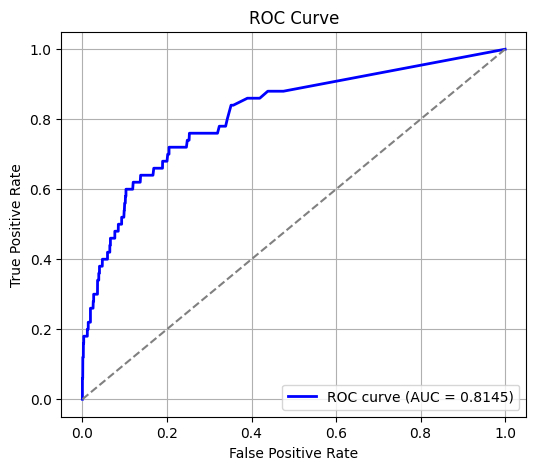

In [129]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test_lasso, y_pred_proba_et_lasso)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

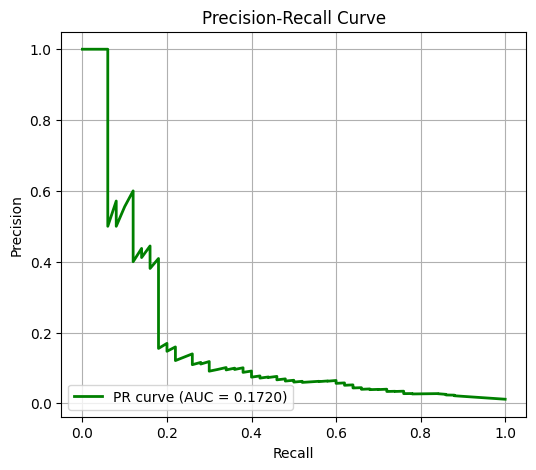

In [130]:
# PR Curve
precision, recall, _ = precision_recall_curve(y_test_lasso, y_pred_proba_et_lasso)
pr_auc = average_precision_score(y_test_lasso, y_pred_proba_et_lasso)

plt.figure(figsize=(6, 5))
plt.plot(recall, precision, color='green', lw=2, label=f'PR curve (AUC = {pr_auc:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

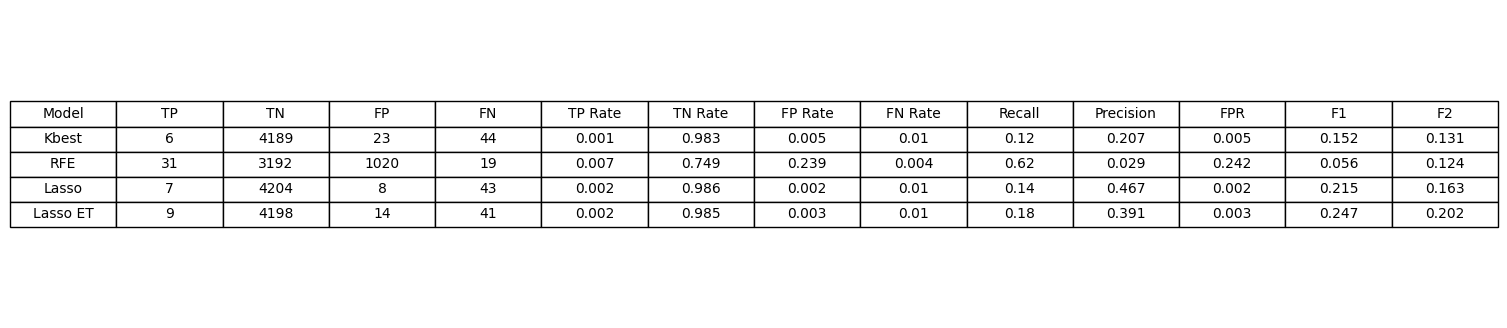

In [131]:
# Print a table to summarize the results
summary_table = pd.concat([summary_df_kbest, summary_df_rfe, summary_df_lasso, summary_df_et_lasso], ignore_index=True)
summary_table = summary_table[['title', 'count_true_positive', 'count_true_negative',
                               'count_false_positive', 'count_false_negative', 'true_positive_score', 'true_negative_score',
                               'false_positive_score', 'false_negative_score', 'recall_score', 'precision_score',
                               'false_positive_rate_score', 'f1_score', 'f2_score']]

# Rename them
summary_table.columns = ['Model', 'TP', 'TN', 'FP', 'FN',
                         'TP Rate', 'TN Rate', 'FP Rate', 'FN Rate',
                         'Recall', 'Precision', 'FPR', 'F1', 'F2']
                         
# summary_table.to_csv('flagging_analysis_summary.csv', index=False)
import matplotlib.pyplot as plt

# Set up figure and axis
fig, ax = plt.subplots(figsize=(16, 4))  # Adjust width/height as needed
ax.axis('off')  # Hide axes

# Create table from DataFrame
table = ax.table(cellText=summary_table.round(3).values,
                 colLabels=summary_table.columns,
                 loc='center',
                 cellLoc='center')

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.5)  # Adjust cell size

# Save as image
plt.show()

In [132]:
summary_table

Model  TP    TN    FP  FN   TP Rate   TN Rate   FP Rate   FN Rate  \
0     Kbest   6  4189    23  44  0.001408  0.982872  0.005397  0.010324   
1       RFE  31  3192  1020  19  0.007274  0.748944  0.239324  0.004458   
2     Lasso   7  4204     8  43  0.001642  0.986391  0.001877  0.010089   
3  Lasso ET   9  4198    14  41  0.002112  0.984984  0.003285  0.009620   

   Recall  Precision       FPR        F1        F2  
0    0.12   0.206897  0.005461  0.151899  0.131004  
1    0.62   0.029496  0.242165  0.056312  0.123901  
2    0.14   0.466667  0.001899  0.215385  0.162791  
3    0.18   0.391304  0.003324  0.246575  0.201794

### Conclusions
Using Random Forest Extra Trees with Lasso features appears to offer the best trade-off between catching positives and avoiding false alarms. RFE, while good for recall, introduces too much noise. Plain Lasso is a solid choice if minimizing false positives is the main goal.

The ROC AUC score of 0.8145 indicates that the models are generally good at distinguishing between the two classes.
However, the Precision-Recall AUC is only 0.1720 due to class imbalance, making the performance on the positive (minority) class very limited.

## Most Relevant Features
| **Feature**                    | **Importance** | **Insight**                                                                    |
| ------------------------------ | -------------- | ------------------------------------------------------------------------------ |
| `number_of_listings_of_host`   | 0.069          | Fewer listings → **higher** risk. Smaller hosts have more tendency to complain |
| `listing_number_of_bedrooms`   | 0.066          | More bedrooms → **higher** risk. Larger properties involve higher risk.        |
| `listing_number_of_bathrooms`  | 0.063          | More bathrooms → **higher** risk. Related to larger properties.                |
| `host_months_with_truvi`       | 0.049          | Longer time → **higher** risk.                                                 |
| `host_account_type_PMC`        | 0.035          | PMC hosts → **lower** risk. Professional management mitigates incidents.       |
| `host_country_United Kingdom`  | 0.035          | UK-based hosts → **lower** risk. Possibly due to operational/regional norms.   |
| `number_of_nights`             | 0.034          | Longer stays → **higher** risk. Increased time/possibility to issues.          |
| `guest_age`                    | 0.033          | Younger guests → **higher** risk. May reflect behavioral trends.               |
| `host_age`                     | 0.031          | Older hosts → **higher** risk. Possibly less adaptive to platform dynamics.    |
| `host_active_pms_list_Hostify` | 0.030          | Hostify users → **lower** risk.                                                |

